# Projet : 4 
# Anticipez les besoins en consommation de bâtiments

#### Contexte

Afin d'atteindre l'objectif de devenir une ville neutre en émissions de carbone d'ici 2050, la ville de Seattle accorde une grande importance à l'évaluation des émissions provenant des bâtiments non destinés à l'habitation. Des relevés minutieux ont été effectués en 2016. Cependant, ces relevés sont coûteux à réaliser, et compte tenu de ceux déjà effectués, nous devons maintenant chercher à prédire les émissions de CO2 et la consommation totale d'énergie des bâtiments pour lesquels ces données n'ont pas encore été mesurées.

## Première Partie : Analyse_Exploratoire


### Importation des Packages

#### Importation des Librairies

In [1]:
# Importation des librairies nécessaires

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import json  
from pandas.io.json import json_normalize  

#### Modification des affichages de colonnes, lignes et largeurs de colonnes afin d'obtenir un maximum d'informations.

In [2]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes afin d'obtenir un maximum d'informations.
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)

/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_2770/847873684.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


#### Importation des Données

In [3]:
# On affiche le chemin menant à notre dataset.
data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

#On affiche les 5 premières lignes du DataFrame
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


### Nettoyage et Tri des features

In [4]:
# On affiche la structure du DataFrame
print(data.shape)

(3376, 46)


In [5]:
# On affiche le nombre de valeurs uniques pour la colonne.
data['Comments'].nunique()

0

In [6]:
# On retire la colonne 'Comment' dans le dataset
data.drop(['Comments'], axis=1, inplace=True)

Cette fonction extrait les informations d'adresse et de localisation contenues dans la colonne "Location" d'un DataFrame, les transforme en nouvelles colonnes, puis fusionne les nouvelles informations avec le DataFrame d'origine pour créer un DataFrame mis à jour avec les informations supplémentaires.

In [7]:
import ast

def transform_columns (dataframe):
    '''Récupère les informations contenues dans la colonne Location pour les 
    ajouter dans des nouvelles colonnes du dataframe.
    La fonction renvoie le dataframe avec les nouvelles colonnes et l'ancienne
    purgée.
    '''
        
    #ajout des informations des colonnes manquantes
    location = pd.DataFrame()
    for line, building_id in zip(data['Location'], data['OSEBuildingID']):
        line = ast.literal_eval(line)
        line = json_normalize(line)
        
        latitude = line['latitude'][0]
        longitude = line['longitude'][0]

        line = pd.DataFrame(ast.literal_eval(line['human_address'][0]), index=[0])
        location = pd.concat([location,
                             pd.DataFrame({
                       'Building_id' : building_id,
                       'Address' : line['address'][0],
                       'City' : line['city'][0],
                       'State' : line['state'][0],
                       'ZipCode' : line['zip'][0],
                       'Latitude' : latitude,
                       'Longitude': longitude }, index=[0])],
                             axis=0)
    return pd.merge(dataframe, location, left_on = 'OSEBuildingID', 
                    right_on = 'Building_id').drop(['Building_id','Location'],axis=1)

In [8]:
# On affiche les statistiques éléméntaires de variable 'TotalGHGEmissions'
data['TotalGHGEmissions'].describe()

count    3367.000000 
mean     119.723971  
std      538.832227  
min     -0.800000    
25%      9.495000    
50%      33.920000   
75%      93.940000   
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

In [9]:
# On affiche les statistiques éléméntaires de variable 'GHGEmissionsIntensity'
data['GHGEmissionsIntensity'].describe()

count    3367.000000
mean     1.175916   
std      1.821452   
min     -0.020000   
25%      0.210000   
50%      0.610000   
75%      1.370000   
max      34.090000  
Name: GHGEmissionsIntensity, dtype: float64

#### Vérification des types

In [10]:
# On verifie le type de variables du DataFrame
pd.DataFrame([data.dtypes])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,int64,int64,object,object,object,object,object,object,float64,object,int64,object,float64,float64,int64,float64,int64,int64,int64,int64,object,object,float64,object,float64,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,object,object,float64,float64


In [11]:
data['DefaultData'] = data['DefaultData'].map({'Yes' : True, 'No' : False}).head()

In [12]:
data[['Latitude','Longitude', 'ZipCode']] = data[['Latitude','Longitude', 'ZipCode']].astype('float64')

In [13]:
#On affiche les 5 premières lignes de la colonne ZipCode(code postal)
data[['ZipCode']].head()

,ZipCode
0,98101.0
1,98101.0
2,98101.0
3,98101.0
4,98121.0


In [14]:
# On affiche la structure du DataFrame
data.shape

(3376, 45)

In [15]:
# Affichons le nombre de valeurs NaN de DataFrame
data.isna().sum().sum()

19952

#### Types de colonnes

In [16]:
# On affiche le type de variables du DataFrame
data.dtypes

OSEBuildingID                      int64  
DataYear                           int64  
BuildingType                       object 
PrimaryPropertyType                object 
PropertyName                       object 
Address                            object 
City                               object 
State                              object 
ZipCode                            float64
TaxParcelIdentificationNumber      object 
CouncilDistrictCode                int64  
Neighborhood                       object 
Latitude                           float64
Longitude                          float64
YearBuilt                          int64  
NumberofBuildings                  float64
NumberofFloors                     int64  
PropertyGFATotal                   int64  
PropertyGFAParking                 int64  
PropertyGFABuilding(s)             int64  
ListOfAllPropertyUseTypes          object 
LargestPropertyUseType             object 
LargestPropertyUseTypeGFA          float64
SecondLarge

#### Observations

- On parcourt toutes les colonnes du DataFrame "data". S'il y a moins de 20 valeurs uniques dans une colonne, il affiche le nom de la colonne et la liste des valeurs uniques. Sinon, il affiche simplement le nom de la colonne et le nombre de valeurs uniques. Cela peut être utile pour avoir un aperçu rapide de la distribution des valeurs dans chaque colonne du DataFrame.

In [17]:
#affiche simplement le nom de la colonne et le nombre de valeurs uniques
for column in data.columns:
    if data[column].nunique()<20:
        print('Colonne {}, valeurs uniques :\n{}\n'.format(column, data[column].unique()))
    else:
        print('Colonne {}, {} valeurs uniques'.format(column, data[column].nunique()))

Colonne OSEBuildingID, 3376 valeurs uniques
Colonne DataYear, valeurs uniques :
[2016]

Colonne BuildingType, valeurs uniques :
['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']

Colonne PrimaryPropertyType, 24 valeurs uniques
Colonne PropertyName, 3362 valeurs uniques
Colonne Address, 3354 valeurs uniques
Colonne City, valeurs uniques :
['Seattle']

Colonne State, valeurs uniques :
['WA']

Colonne ZipCode, 55 valeurs uniques
Colonne TaxParcelIdentificationNumber, 3268 valeurs uniques
Colonne CouncilDistrictCode, valeurs uniques :
[7 3 2 4 5 6 1]

Colonne Neighborhood, valeurs uniques :
['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'Central' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'CENTRAL' 'SOUTHWEST' 'DELRIDGE' 'Ballard' 'North' 'Delridge'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']

Colonne Latitude, 2876 valeurs uniques
Colonne Longit

#### Catégorisation
Traitement "Compliance Status"

- On définis une liste appelée "columns_to_categorize" qui contient le nom de certaines colonnes d'un jeu de données, que l'on souhaite traiter comme des catégories (ou variables catégorielles) plutôt que comme des valeurs numériques continues

In [18]:
columns_to_categorize = ['DataYear', 'BuildingType', 'CouncilDistrictCode',
                        'ComplianceStatus', 'Outlier', 'Neighborhood']

In [19]:
data[columns_to_categorize] = data[columns_to_categorize].astype('category')

#### Types

In [20]:
# On affiche le type de variables du DataFrame
data.dtypes

OSEBuildingID                      int64   
DataYear                           category
BuildingType                       category
PrimaryPropertyType                object  
PropertyName                       object  
Address                            object  
City                               object  
State                              object  
ZipCode                            float64 
TaxParcelIdentificationNumber      object  
CouncilDistrictCode                category
Neighborhood                       category
Latitude                           float64 
Longitude                          float64 
YearBuilt                          int64   
NumberofBuildings                  float64 
NumberofFloors                     int64   
PropertyGFATotal                   int64   
PropertyGFAParking                 int64   
PropertyGFABuilding(s)             int64   
ListOfAllPropertyUseTypes          object  
LargestPropertyUseType             object  
LargestPropertyUseTypeGFA       

In [21]:
# Affichons le nombre de valeurs NaN de DataFrame
data.isna().sum().sum()

19952

#### Valeurs négatives

- data.min() est une méthode couramment utilisée pour trouver la valeur minimale d'un ensemble de données, que ce soit une liste, un tableau ou une série.

In [22]:
data.min()

/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_2770/927168777.py:1: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.min()


OSEBuildingID                      1                          
PrimaryPropertyType                Distribution Center        
PropertyName                       #4706 Bitterlake           
Address                            (ID23682) 3204 SW MORGAN ST
City                               Seattle                    
State                              WA                         
ZipCode                            98006.0                    
TaxParcelIdentificationNumber      0000000000                 
Latitude                           47.49917                   
Longitude                         -122.41425                  
YearBuilt                          1900                       
NumberofBuildings                  0.0                        
NumberofFloors                     0                          
PropertyGFATotal                   11285                      
PropertyGFAParking                 0                          
PropertyGFABuilding(s)             3636                

kBtu = kilo british termal unit Il y a des valeurs négatives mais le bâtiment producteur d'énergie existent, pas de suppression de valeurs négative à ce stade

In [23]:
#On affiche aléatoirement les 10 premières lignes de la colonne 'Latitude'
data[['Latitude']].sample(10)

,Latitude
1988,47.69316
2862,47.61314
272,47.60968
3323,47.56081
2507,47.56430
1776,47.59018
196,47.61069
440,47.66113
36,47.51138
2049,47.55464


#### Localisation

- On utilise principalement la bibliothèque Folium pour créer une carte interactive affichant des cercles à des emplacements spécifiques.

In [24]:
if False:
    
    import folium
    m = folium.Map()
    m = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()],
                   zoom_start=11)
    for i in range(0,len(data)):
        folium.Circle([data.iloc[i]['Latitude'],data.iloc[i]['Longitude']], 
                      popup=data.iloc[i]['Address'], radius =100).add_to(m)
    m

La localisation correspond bien à la ville de Seattle

#### Outliers
- Observation de la colonne "Outlier"

In [25]:
# On affiche les statistique élementaire des valeurs manquantes 
data[~data['Outlier'].isna()].describe()

,OSEBuildingID,ZipCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,16.00000,7.000000,23.000000,32.000000,32.000000,32.000000,32.000000,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,32.000000,3.200000e+01,32.000000,32.000000
mean,23372.375000,98113.281250,47.604886,-122.340433,1950.531250,1.156250,4.062500,53753.562500,2608.812500,51144.750000,46763.843750,16725.12500,5359.857143,77.652174,56.331250,57.956251,139.221875,142.190626,4.239594e+06,4.339862e+06,2.720186e+05,8.687200e+05,2.964073e+06,7146.245987,7.146246e+05,79.613125,1.275313
std,11554.179215,10.674765,0.037508,0.027881,37.150943,0.723316,4.031629,43188.452471,8957.194547,39376.585684,39740.329946,25582.46359,8849.551108,40.811773,87.396706,88.995301,254.492484,257.334195,8.869577e+06,8.956811e+06,1.538770e+06,2.430097e+06,8.291490e+06,19106.924587,1.910692e+06,164.807224,2.561277
min,350.000000,98101.000000,47.517090,-122.401470,1900.000000,1.000000,1.000000,20039.000000,0.000000,20039.000000,17822.000000,0.00000,0.000000,1.000000,0.400000,0.400000,1.100000,1.100000,1.340900e+04,1.340900e+04,0.000000e+00,3.332500e+03,1.137000e+04,0.000000,0.000000e+00,0.090000,0.000000
25%,20554.500000,98104.000000,47.582763,-122.353792,1910.000000,1.000000,2.000000,26058.250000,0.000000,26058.250000,23957.250000,2305.00000,857.000000,86.500000,4.500000,4.575000,13.275000,13.675000,1.361517e+05,1.448247e+05,0.000000e+00,3.040798e+04,1.037520e+05,0.000000,0.000000e+00,1.110000,0.040000
50%,24229.500000,98110.500000,47.607980,-122.335245,1955.500000,1.000000,3.000000,39556.000000,0.000000,37508.500000,26339.500000,9133.00000,2000.000000,100.000000,8.950000,9.300000,25.200000,26.750000,2.704143e+05,2.923130e+05,0.000000e+00,6.545780e+04,2.233420e+05,0.000000,0.000000e+00,5.060000,0.140000
75%,26890.750000,98122.000000,47.621390,-122.322198,1982.500000,1.000000,4.000000,51750.000000,0.000000,51750.000000,52370.000000,14460.00000,4402.500000,100.000000,106.275002,112.275002,205.449997,208.399998,4.540035e+06,4.731598e+06,0.000000e+00,4.823374e+05,1.645735e+06,2061.519684,2.061520e+05,60.285000,1.495000
max,50071.000000,98134.000000,47.701880,-122.278800,2015.000000,5.000000,24.000000,172842.000000,42500.000000,167941.000000,193154.000000,99952.00000,25000.000000,100.000000,311.700012,311.700012,978.900024,978.900024,4.139950e+07,4.165040e+07,8.704596e+06,1.166315e+07,3.979467e+07,94960.359380,9.496036e+06,686.530000,11.380000


In [26]:
# On affiche les statistique élementaire des valeurs manquantes
data[data['Outlier'].isna()].describe()

,OSEBuildingID,ZipCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3344.000000,3328.000000,3344.000000,3344.000000,3344.000000,3336.000000,3344.000000,3.344000e+03,3344.000000,3.344000e+03,3.324000e+03,1663.000000,589.000000,2510.000000,3337.000000,3338.000000,3335.000000,3335.000000,3.339000e+03,3.338000e+03,3.335000e+03,3.335000e+03,3.335000e+03,3.335000e+03,3.335000e+03,3335.000000,3335.000000
mean,21188.288876,98116.984375,47.624216,-122.334741,1968.745813,1.106415,4.715311,9.522665e+04,8053.130981,8.717352e+04,7.948968e+04,28556.825795,11814.484548,67.829482,54.716782,57.024955,134.184978,137.741649,5.414823e+06,5.285707e+06,2.746206e+05,1.088730e+06,3.714747e+06,1.374779e+04,1.374779e+06,120.108843,1.174963
std,12229.772762,18.672612,0.047813,0.027195,33.005479,2.117339,5.506665,2.198061e+05,32465.292287,2.088688e+05,2.026107e+05,54587.821013,29483.416793,26.707896,55.910975,56.792574,137.785292,137.554922,2.169684e+07,1.599148e+07,3.928102e+06,4.366981e+06,1.490014e+07,6.739079e+04,6.739079e+06,541.164241,1.813405
min,1.000000,98006.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,-0.800000,-0.020000
25%,19989.500000,98105.000000,47.600180,-122.350552,1948.750000,1.000000,2.000000,2.852325e+04,0.000000,2.779100e+04,2.515075e+04,5000.000000,2351.000000,53.000000,28.100000,29.500000,75.000000,78.699997,9.351888e+05,9.832379e+05,0.000000e+00,1.887718e+05,6.440895e+05,0.000000e+00,0.000000e+00,9.655000,0.210000
50%,23108.500000,98115.000000,47.618875,-122.332475,1975.000000,1.000000,4.000000,4.429100e+04,0.000000,4.322800e+04,3.996100e+04,10751.000000,5100.000000,75.000000,38.700001,40.900002,96.400002,101.300003,1.809102e+06,1.914797e+06,0.000000e+00,3.467298e+05,1.183042e+06,3.294022e+03,3.294020e+05,34.110000,0.620000
75%,25992.500000,98122.000000,47.657293,-122.319345,1997.000000,1.000000,5.000000,9.115075e+04,0.000000,8.441625e+04,7.676675e+04,26770.000000,10270.000000,90.000000,60.400002,64.199997,143.849998,148.300003,4.218830e+06,4.379956e+06,0.000000e+00,8.310218e+05,2.835446e+06,1.193213e+04,1.193214e+06,94.015000,1.370000
max,50226.000000,98272.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


In [27]:
# On affiche aléatoirement les statistique élementaire des valeurs manquantes
data[~data['Outlier'].isna()].sample(10)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1707,23174,2016,Multifamily LR (1-4),Mid-Rise Multifamily,Taylor Anne Condominium,1730 Taylor Ave N,Seattle,WA,98109.0,8567250000,7,MAGNOLIA / QUEEN ANNE,47.63435,-122.34671,1969,1.0,5,30569,0,30569,Multifamily Housing,Multifamily Housing,30921.0,NaN,NaN,NaN,NaN,NaN,1.0,221.000000,231.899994,684.299988,717.200012,6.834431e+06,7.169577e+06,0.0,1.961078e+06,6691197.0,1432.329956,143233.0,NaN,Non-Compliant,High outlier,54.25,1.77
2476,25756,2016,Multifamily LR (1-4),Low-Rise Multifamily,West Olympic Condominiums,5601 California Avenue SW,Seattle,WA,98116.0,9270000000,1,SOUTHWEST,47.55190,-122.38753,1978,1.0,4,22000,0,22000,"Multifamily Housing, Parking",Multifamily Housing,22000.0,Parking,10000.0,NaN,NaN,NaN,100.0,7.000000,7.600000,22.100000,23.799999,1.547981e+05,1.670468e+05,0.0,4.536870e+04,154798.0,0.000000,0.0,NaN,Non-Compliant,Low outlier,1.08,0.05
1611,22830,2016,NonResidential,Worship Facility,Freedom Church,9601 35th Ave,Seattle,WA,98126.0,2858600090,1,SOUTHWEST,47.51709,-122.37797,1971,1.0,1,23772,0,23772,Worship Facility,Worship Facility,23772.0,NaN,NaN,NaN,NaN,NaN,100.0,4.200000,4.200000,13.300000,13.300000,1.008417e+05,1.008417e+05,0.0,2.955500e+04,100842.0,0.000000,0.0,NaN,Non-Compliant,Low outlier,0.70,0.03
2189,24717,2016,NonResidential,Other,1701 First Ave South LLC,1701 First Ave South,Seattle,WA,98134.0,7666207085,2,GREATER DUWAMISH,47.58788,-122.33458,1910,1.0,3,27690,0,27690,"Other, Parking",Other,24717.0,Parking,0.0,NaN,NaN,NaN,NaN,0.700000,0.700000,2.100000,2.200000,1.680890e+04,1.726000e+04,0.0,4.926400e+03,16809.0,0.000000,0.0,NaN,Non-Compliant,Low outlier,0.12,0.00
2129,24547,2016,NonResidential,K-12 School,Islamic School of Seattle,720 25TH AVE,Seattle,WA,98122.0,6840700175,3,CENTRAL,47.60885,-122.29990,1929,1.0,2,24152,0,24152,K-12 School,K-12 School,24152.0,NaN,NaN,NaN,NaN,NaN,100.0,6.700000,6.700000,21.000000,21.000000,1.613634e+05,1.613634e+05,0.0,4.729290e+04,161363.0,0.000000,0.0,NaN,Non-Compliant,Low outlier,1.12,0.05
1295,21474,2016,NonResidential,Other,The Lusty Lady,1315 1st Ave,Seattle,WA,98101.0,1976200060,7,DOWNTOWN,47.60711,-122.33886,1900,1.0,3,49760,0,49760,Other,Other,24019.0,NaN,NaN,NaN,NaN,NaN,NaN,1.800000,1.800000,5.800000,5.800000,4.429350e+04,4.429350e+04,0.0,1.298170e+04,44294.0,0.000000,0.0,NaN,Non-Compliant,Low outlier,0.31,0.01
2410,25553,2016,NonResidential,Hotel,J & M HOTEL BUILDING (ID25553),210 1St Ave S,Seattle,WA,98104.0,5247800130,7,DOWNTOWN,47.60035,-122.33379,1900,1.0,3,25450,0,25450,Hotel,Hotel,25450.0,NaN,NaN,NaN,NaN,NaN,99.0,19.799999,19.400000,62.200001,60.799999,5.037447e+05,4.928446e+05,0.0,1.476391e+05,503745.0,0.000000,0.0,NaN,Non-Compliant,Low outlier,3.51,0.14
834,19934,2016,Multifamily LR (1-4),Low-Rise Multifamily,Belmont Lofts,231 Belmont Ave E,Seattle,WA,98102.0,0704600000,3,EAST,47.62059,-122.32440,1989,1.0,4,31702,0,31702,"Multifamily Housing, Parking",Multifamily Housing,26418.0,Parking,14280.0,NaN,NaN,NaN,NaN,9.700000,10.400000,30.400000,32.700001,2.559712e+05,2.754120e+05,0.0,7.502090e+04,255971.0,0.000000,0.0,NaN,Non-Compliant,Low outlier,1.78,0.06
720,19708,2016,Multifamily HR (10+),High-Rise Multifamily,Bay Vista,2821 2nd Ave,Seattle,WA,98121.0,0586400000,7,DOWNTOW

#### Analyse des outliers

In [28]:
# On affiche le type de variables de notre DataFrame pour analyse des Outliers 
data.dtypes

OSEBuildingID                      int64   
DataYear                           category
BuildingType                       category
PrimaryPropertyType                object  
PropertyName                       object  
Address                            object  
City                               object  
State                              object  
ZipCode                            float64 
TaxParcelIdentificationNumber      object  
CouncilDistrictCode                category
Neighborhood                       category
Latitude                           float64 
Longitude                          float64 
YearBuilt                          int64   
NumberofBuildings                  float64 
NumberofFloors                     int64   
PropertyGFATotal                   int64   
PropertyGFAParking                 int64   
PropertyGFABuilding(s)             int64   
ListOfAllPropertyUseTypes          object  
LargestPropertyUseType             object  
LargestPropertyUseTypeGFA       

In [29]:
# On affiche la structure du DataFrame pour analyse des Outliers 
data.shape

(3376, 45)

On utilise la bibliothèque Seaborn pour générer des graphiques de distribution pour chaque colonne numérique (int32 et float64) d'un DataFrame appelé 'data', puis les affiche tous ensemble à l'aide de plt.show(). Cela permet de visualiser rapidement les distributions des données numériques dans le DataFrame.

/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_2770/1505814095.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[column], bins=30)
/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_2770/1505814095.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[column], bins=

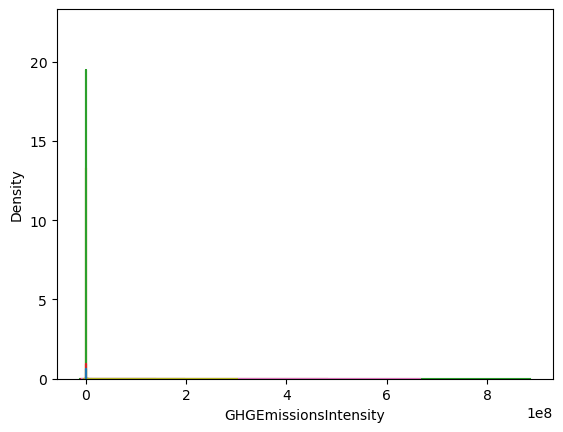

In [30]:
# Code pour afficher les distributions des colonnes numériques (int32, float64)
for column in data.select_dtypes(['int32', 'float64']):
    sns.distplot(data[column], bins=30)

# Code supplémentaire pour l’affichage des parcelles
plt.show()

#### Suppression des outliers

In [31]:
# On affiche la structure du DataFrame pour la suppresion des Outliers
data.shape

(3376, 45)

On semble effectuer la détection et la suppression de valeurs aberrantes en utilisant une approche basée sur KDTree dans la bibliothèque scikit-learn (sklearn). 

In [32]:
from sklearn.neighbors import KDTree

for column in data.select_dtypes(include = ['int32','float64']).columns.tolist() :
    "outliers aux extrémités des distributions"
    data.loc[data[column] > data[column].quantile(0.995)] = np.nan
    data.loc[data[column] < data[column].quantile(0.005)] = np.nan
print(data.shape)
    
#outliers éloignés par rapport à leurs voisins
numeric_data = data.select_dtypes(['int32', 'float64']).copy().dropna()
print(numeric_data.shape)
kdt = KDTree(numeric_data, leaf_size = 40, metric='minkowski')

dist, ind = kdt.query(numeric_data, k=3, return_distance=True)
numeric_data['3N_distance'] = np.sum(dist, axis=1)    
numeric_data = numeric_data[numeric_data['3N_distance'] < numeric_data['3N_distance'].quantile(0.99)]
index_to_drop = numeric_data.index.tolist()

data = data.drop(index_to_drop, axis=0)

(3376, 45)
(225, 27)


Correction du nombre de bâtiments (ne peut être nul)

- On effectue une mise à jour des valeurs dans la colonne 'NumberofBuildings' du DataFrame 'data'. Il change toutes les occurrences où le nombre de bâtiments est égal à zéro en les mettant à jour avec une valeur de 1. Cela peut être utile pour remplacer des valeurs nulles par des valeurs significatives lorsque l'on travaille avec des données contenant des informations sur le nombre de bâtiments, et par exemple, éviter des problèmes lors de calculs futurs ou d'analyses statistiques.

In [33]:
data.loc[data['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1

In [34]:
# Affichons le nombre de valeurs NaN de DataFrame
data.isna().sum().sum()

38988

#### Valeurs Manquantes ( NaN )

In [35]:
# On affiche la structure du DataFrame pour trouver les valeurs manquantes
data.shape

(3154, 45)

In [36]:
# On affiche  le nombre de valeurs nulles dans notre DataFrame
data_nan = data.isna().sum().sort_values(ascending=False).head(15)

In [37]:
data_nan

DefaultData                        3154
Outlier                            3148
YearsENERGYSTARCertified           3096
ThirdLargestPropertyUseType        2902
ThirdLargestPropertyUseTypeGFA     2902
SecondLargestPropertyUseType       1959
SecondLargestPropertyUseTypeGFA    1959
ENERGYSTARScore                    1164
LargestPropertyUseTypeGFA          521 
LargestPropertyUseType             521 
SourceEUIWN(kBtu/sf)               510 
SourceEUI(kBtu/sf)                 510 
ListOfAllPropertyUseTypes          510 
Electricity(kWh)                   510 
Electricity(kBtu)                  510 
dtype: int64

Représentons la proportion de valeurs manquantes (NaN) pour chaque variable d'un jeu de données data sous forme de pourcentage.

<Axes: title={'center': 'Proportion de NaN par variable (%)'}>

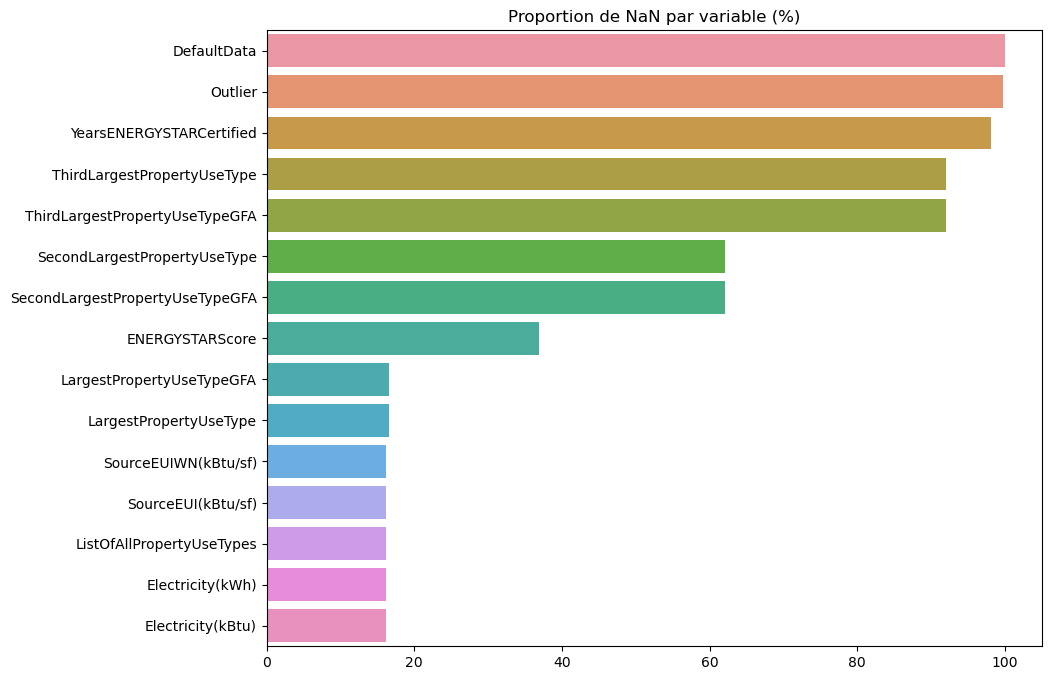

In [38]:
plt.figure(figsize=(10,8))
plt.title('Proportion de NaN par variable (%)')
sns.barplot(x=data_nan.values/data.shape[0]*100, y=data_nan.index)

La boucle parcourt chaque colonne de l'ensemble de données, puis affiche le nom de la colonne, le pourcentage de valeurs manquantes dans la colonne, ainsi que le nombre de valeurs uniques présentes dans cette colonne. Cela peut être utile pour obtenir rapidement un aperçu de la qualité des données et identifier les colonnes potentiellement problématiques avec de nombreuses valeurs manquantes ou peu de diversité dans les valeurs.

In [39]:
for colonne in data.columns:
    print('\n',colonne)
    print('Qté Nan : ', round(data[colonne].isna().sum()/data[colonne].shape[0]*100), '%')
    print('Uniques : ', data[colonne].nunique())


 OSEBuildingID
Qté Nan :  16 %
Uniques :  2653

 DataYear
Qté Nan :  16 %
Uniques :  1

 BuildingType
Qté Nan :  16 %
Uniques :  8

 PrimaryPropertyType
Qté Nan :  16 %
Uniques :  24

 PropertyName
Qté Nan :  16 %
Uniques :  2644

 Address
Qté Nan :  16 %
Uniques :  2637

 City
Qté Nan :  16 %
Uniques :  1

 State
Qté Nan :  16 %
Uniques :  1

 ZipCode
Qté Nan :  16 %
Uniques :  36

 TaxParcelIdentificationNumber
Qté Nan :  16 %
Uniques :  2589

 CouncilDistrictCode
Qté Nan :  16 %
Uniques :  7

 Neighborhood
Qté Nan :  16 %
Uniques :  19

 Latitude
Qté Nan :  16 %
Uniques :  2314

 Longitude
Qté Nan :  16 %
Uniques :  2165

 YearBuilt
Qté Nan :  16 %
Uniques :  112

 NumberofBuildings
Qté Nan :  16 %
Uniques :  6

 NumberofFloors
Qté Nan :  16 %
Uniques :  30

 PropertyGFATotal
Qté Nan :  16 %
Uniques :  2521

 PropertyGFAParking
Qté Nan :  16 %
Uniques :  318

 PropertyGFABuilding(s)
Qté Nan :  16 %
Uniques :  2515

 ListOfAllPropertyUseTypes
Qté Nan :  16 %
Uniques :  292

 Largest

In [40]:
# On retire la colonne 'Outlier' dans le dataset et on affiche la structure 
data.drop(['Outlier'],axis=1).dropna().shape

(0, 44)

In [41]:
# On affiche la structure du DataFrame
data.shape

(3154, 45)

In [42]:
# On affiche le nombre de valeurs nulles dans notre DataFrame /  et on affiche aussi la structure.
((data.isna().sum()/data.shape[0]) < .99)

OSEBuildingID                      True 
DataYear                           True 
BuildingType                       True 
PrimaryPropertyType                True 
PropertyName                       True 
Address                            True 
City                               True 
State                              True 
ZipCode                            True 
TaxParcelIdentificationNumber      True 
CouncilDistrictCode                True 
Neighborhood                       True 
Latitude                           True 
Longitude                          True 
YearBuilt                          True 
NumberofBuildings                  True 
NumberofFloors                     True 
PropertyGFATotal                   True 
PropertyGFAParking                 True 
PropertyGFABuilding(s)             True 
ListOfAllPropertyUseTypes          True 
LargestPropertyUseType             True 
LargestPropertyUseTypeGFA          True 
SecondLargestPropertyUseType       True 
SecondLargestPro

 On filtre les colonnes du DataFrame 'data' en ne conservant que celles qui ont moins de 99% de valeurs manquantes (NaN) et stocke le résultat dans la DataFrame 'data' mise à jour.

In [43]:
liste_colonnes = []
serie_nan = data.isna().sum()/data.shape[0] < .9
for colonne, booleen in zip(serie_nan.index, serie_nan.values):
    if booleen :
        liste_colonnes.append(colonne)
data = data[liste_colonnes]

On élimine les colonnes d'un DataFrame qui contiennent plus de 90% de valeurs manquantes, et conserve uniquement les colonnes qui ont moins de 90% de valeurs manquantes.

In [44]:
# On affiche toutes les colonnes du DataFrame
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'ComplianceStatus', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

On affiche un graphique avec le titre "Distribution du nombre de NaN par ligne" et un histogramme montrant la fréquence des différentes valeurs du nombre de valeurs manquantes (NaN) par ligne dans le DataFrame data. Cela peut être utile pour visualiser la répartition des valeurs manquantes dans les données et identifier les lignes qui ont un grand nombre de valeurs manquantes.

/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_2770/519702927.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.isna().sum(axis=1))


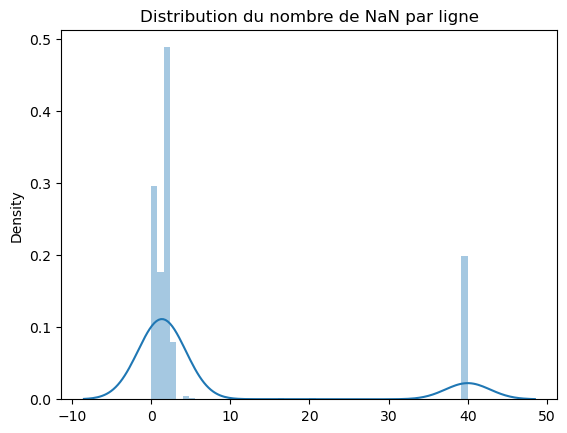

In [45]:
# On affiche la distribution du nombre de NaN par ligne de notre DataFrame
plt.title('Distribution du nombre de NaN par ligne')
sns.distplot(data.isna().sum(axis=1))
plt.show()

On sélectionne un sous-ensemble de colonnes du DataFrame 'data', puis compte le nombre de valeurs manquantes dans chacune de ces colonnes. Le résultat final sera un DataFrame montrant le nombre de valeurs manquantes pour chaque colonne spécifiée.

In [46]:
data[[
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',]].isna().sum()

SiteEUI(kBtu/sf)         506
SiteEUIWN(kBtu/sf)       506
SourceEUI(kBtu/sf)       510
SourceEUIWN(kBtu/sf)     510
SiteEnergyUse(kBtu)      506
SiteEnergyUseWN(kBtu)    506
SteamUse(kBtu)           510
Electricity(kWh)         510
Electricity(kBtu)        510
NaturalGas(therms)       510
NaturalGas(kBtu)         510
dtype: int64

On permet d'identifier et de compter le nombre de valeurs manquantes pour chaque colonne du DataFrame et de les afficher dans l'ordre décroissant, mettant en évidence les colonnes avec le plus grand nombre de valeurs manquantes en premier. Cela peut être utile pour repérer les colonnes nécessitant une attention particulière lors du nettoyage ou de l'analyse des données.

In [47]:
# On affiche le nombre de valeurs nulles dans notre DataFrame.
data.isna().sum().sort_values(ascending=False)

SecondLargestPropertyUseTypeGFA    1959
SecondLargestPropertyUseType       1959
ENERGYSTARScore                    1164
LargestPropertyUseType             521 
LargestPropertyUseTypeGFA          521 
ListOfAllPropertyUseTypes          510 
TotalGHGEmissions                  510 
NaturalGas(kBtu)                   510 
NaturalGas(therms)                 510 
Electricity(kBtu)                  510 
Electricity(kWh)                   510 
SteamUse(kBtu)                     510 
SourceEUIWN(kBtu/sf)               510 
SourceEUI(kBtu/sf)                 510 
GHGEmissionsIntensity              510 
ZipCode                            510 
NumberofBuildings                  509 
SiteEUI(kBtu/sf)                   506 
SiteEnergyUseWN(kBtu)              506 
SiteEnergyUse(kBtu)                506 
SiteEUIWN(kBtu/sf)                 506 
YearBuilt                          501 
PropertyGFATotal                   501 
BuildingType                       501 
ComplianceStatus                   501 


On prend un DataFrame appelé 'data', sélectionne toutes les colonnes contenant des chaînes de caractères, puis calcule le nombre d'éléments uniques dans chacune de ces colonnes, et enfin affiche le résultat trié par ordre croissant du nombre d'éléments uniques par colonne. Cela peut être utile pour avoir un aperçu rapide des colonnes avec le moins de diversité dans les données, ce qui peut être important pour détecter des colonnes potentiellement peu informatives ou problématiques dans le jeu de données.

In [48]:
# On affiche le nombre de types de valeurs uniques pour la colonne.
data.select_dtypes(['object']).nunique().sort_values()

City                             1   
State                            1   
PrimaryPropertyType              24  
SecondLargestPropertyUseType     45  
LargestPropertyUseType           52  
ListOfAllPropertyUseTypes        292 
TaxParcelIdentificationNumber    2589
Address                          2637
PropertyName                     2644
dtype: int64

#### Complétion des NaN par des valeurs quand applicable
- Quand NaN pour usage ou other fuel use : valeur 0

On remplace toutes les valeurs manquantes (NaN) dans la colonne "SecondLargestPropertyUseTypeGFA" du DataFrame 'data' par des zéros. Cela peut être utile pour assurer que les données manquantes sont correctement gérées lors de l'analyse ou du traitement ultérieur des données.

In [49]:
data[['SecondLargestPropertyUseTypeGFA']] = data[['SecondLargestPropertyUseTypeGFA']].fillna(0, )

On remplit les valeurs manquantes de la colonne "LargestPropertyUseType" avec la chaîne de caractères 'No information'. Cela peut être utile pour traiter les données manquantes avant d'effectuer des analyses ou de construire des modèles prédictifs sur l'ensemble de données "data".

In [50]:
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna('No information')

On extrait toutes les lignes du DataFrame 'data' où la colonne 'LargestPropertyUseType' a la valeur 'No information' comme type d'utilisation de la plus grande propriété.

In [51]:
data[data['LargestPropertyUseType'] == 'No information']

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No information,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No information,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No information,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No information,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No information,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No information,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No information,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No information,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No information,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No information,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On donne le nombre de valeurs manquantes pour chaque colonne du DataFrame 'data', trié du plus petit au plus grand nombre de valeurs manquantes. Cela permet de mieux comprendre quelles colonnes ont le plus de valeurs manquantes, ce qui peut être utile pour prendre des décisions concernant le nettoyage ou l'imputation des données manquantes.

In [52]:
# On affiche le nombre de valeurs nulles dans notre DataFrame.
data.isna().sum().sort_values()

SecondLargestPropertyUseTypeGFA    0   
LargestPropertyUseType             0   
OSEBuildingID                      501 
ComplianceStatus                   501 
PropertyGFAParking                 501 
PropertyGFATotal                   501 
NumberofFloors                     501 
YearBuilt                          501 
Longitude                          501 
Latitude                           501 
Neighborhood                       501 
PropertyGFABuilding(s)             501 
TaxParcelIdentificationNumber      501 
CouncilDistrictCode                501 
BuildingType                       501 
PropertyName                       501 
Address                            501 
PrimaryPropertyType                501 
State                              501 
DataYear                           501 
City                               501 
SiteEnergyUseWN(kBtu)              506 
SiteEUI(kBtu/sf)                   506 
SiteEUIWN(kBtu/sf)                 506 
SiteEnergyUse(kBtu)                506 


In [53]:
# On affiche la structure du DataFrame
data.shape

(3154, 40)

On supprime toutes les lignes du DataFrame data qui contiennent uniquement des valeurs manquantes (NaN), et cette opération est effectuée directement sur le DataFrame d'origine (inplace=True). Les autres lignes du DataFrame qui ont au moins une valeur non manquante ne seront pas supprimées.

In [54]:
data.dropna(how = 'all', axis=0, inplace=True)

On génère une liste qui montre le nombre de valeurs manquantes dans chaque colonne de l'ensemble de données data, triées par ordre croissant. Cela peut être utile pour identifier les colonnes avec le moins de données manquantes, ce qui pourrait être important pour décider de la manière de traiter les valeurs manquantes dans l'ensemble de données.

In [55]:
# On affiche le nombre de valeurs nulles dans notre DataFrame.
data.isna().sum().sort_values()

SecondLargestPropertyUseTypeGFA    0   
LargestPropertyUseType             0   
OSEBuildingID                      501 
ComplianceStatus                   501 
PropertyGFAParking                 501 
PropertyGFATotal                   501 
NumberofFloors                     501 
YearBuilt                          501 
Longitude                          501 
Latitude                           501 
Neighborhood                       501 
PropertyGFABuilding(s)             501 
TaxParcelIdentificationNumber      501 
CouncilDistrictCode                501 
BuildingType                       501 
PropertyName                       501 
Address                            501 
PrimaryPropertyType                501 
State                              501 
DataYear                           501 
City                               501 
SiteEnergyUseWN(kBtu)              506 
SiteEUI(kBtu/sf)                   506 
SiteEUIWN(kBtu/sf)                 506 
SiteEnergyUse(kBtu)                506 


#### Suite NaN


- On va retirer les indices pour lesquelles ont a beaucoup de NaN sur une même ligne, notamment pour les features qui ont le plus de NaN

In [56]:
# On affiche la structure du DataFrame
data.shape

(3154, 40)

In [57]:
data.drop(['ENERGYSTARScore'], axis=1)[data.drop(['ENERGYSTARScore'],axis=1).isna().any(axis=1)].shape

(1960, 39)

In [58]:
index_to_drop = data.drop(['ENERGYSTARScore'], axis=1)[data.drop(['ENERGYSTARScore'],axis=1).isna().any(axis=1)].index

In [59]:
data.drop(index_to_drop, axis=0, inplace=True)

In [60]:
# On affiche la structure du DataFrame
data.shape

(1194, 40)

#### Regroupement des données catégorielles

In [61]:
data.select_dtypes(['object', 'category']).nunique().sort_values(ascending=False)

PropertyName                     1191
Address                          1191
TaxParcelIdentificationNumber    1179
ListOfAllPropertyUseTypes        247 
SecondLargestPropertyUseType     45  
LargestPropertyUseType           39  
PrimaryPropertyType              22  
Neighborhood                     18  
BuildingType                     7   
CouncilDistrictCode              7   
ComplianceStatus                 3   
DataYear                         1   
City                             1   
State                            1   
dtype: int64

In [62]:
property_use_types_columns = ['SecondLargestPropertyUseType',
                         'LargestPropertyUseType','PrimaryPropertyType']

In [63]:
usetype_dict = {'Retail Store' : 'Retail',
                'Supermarket/Grocery Store' : 'Retail',
                'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Retail',
                'Automobile Dealership': 'Retail',
                'Convenience Store without Gas Station': 'Retail',
                'Personal Services': 'Retail',
                'Enclosed Mall': 'Retail',
                'Strip Mall': 'Retail',
                'Wholesale Club/Supercenter': 'Retail',
                'Other - Mall': 'Retail',
                'Supermarket / Grocery Stor': 'Retail',
                
                'Food Sales': 'Leisure',
                'Restaurant' : 'Leisure',
                'Other - Restaurant/Bar' : 'Leisure',
                'Food Service': 'Leisure' ,
                'Worship Facility': 'Leisure',
                'Other - Recreation': 'Leisure',
                'Other - Entertainment/Public Assembly': 'Leisure',
                'Performing Arts': 'Leisure',
                'Bar/Nightclub': 'Leisure',
                'Movie Theater': 'Leisure',
                'Museum': 'Leisure',
                'Social/Meeting Hall': 'Leisure',
                'Fitness Center/Health Club/Gym': 'Leisure',
                'Lifestyle Center ': 'Leisure',
                'Fast Food Restaurant': 'Leisure',
                
                'Multifamily Housing' : 'Hotel/Senior Care/Housing',
                'Other - Lodging/Residential': 'Hotel/Senior Care/Housing',
                'Residence Hall/Dormitory': 'Hotel/Senior Care/Housing',
                'Hotel' : 'Hotel/Senior Care/Housing',
                'Senior Care Community' : 'Hotel/Senior Care/Housing',
                'Residential Care Facility' : 'Hotel/Senior Care/Housing',
                'High-Rise Multifamily': 'Hotel/Senior Care/Housing',
                
                'Medical Office' : 'Health',
                
                'Other - Services' : 'Office',
                'Bank Branch' : 'Office',
                'Financial Office' : 'Office',
                'Other - Public Services': 'Office',

                'K-12 School' : 'Education',
                'Other - Education': 'Education',
                'Vocational School' : 'Education', 
                'Adult Education' : 'Education',
                'Pre-school/Daycare': 'Education',
                'University': 'Education',
                'College/University': 'Education',
                'Library': 'Education'
               }

Alors, toutes les occurrences de "Résidentiel" dans la colonne seront remplacées par "Habitation", toutes les occurrences de "Commercial" seront remplacées par "Bureau", et toutes les occurrences de "Industriel" seront remplacées par "Usine".

- On parcourt chaque colonne dans la liste "property_use_types_columns" et effectue le remplacement défini par le dictionnaire "usetype_dict", mettant à jour les valeurs de la colonne "data[column]" en conséquence.

In [64]:
for column in property_use_types_columns:
    data[column] = data[column].replace(usetype_dict)

- On parcourt chaque colonne spécifiée dans la liste "property_use_types_columns" du dataframe "data", compte le nombre d'occurrences de chaque valeur unique dans chaque colonne, puis affiche ces décomptes pour chaque colonne, en les séparant par des lignes vides pour une meilleure lisibilité. Cela peut être utile pour comprendre la distribution des données dans les colonnes sélectionnées et identifier les valeurs les plus fréquentes.

In [65]:
for column in data[property_use_types_columns].columns:
    print(data[column].value_counts())
    print('\n')

Parking                                                 695
Office                                                  179
Retail                                                  132
Leisure                                                 63 
Other                                                   45 
Non-Refrigerated Warehouse                              20 
Hotel/Senior Care/Housing                               11 
Swimming Pool                                           9  
Education                                               8  
Data Center                                             8  
Health                                                  8  
Distribution Center                                     6  
Self-Storage Facility                                   3  
Manufacturing/Industrial Plant                          1  
Other/Specialty Hospital                                1  
Courthouse                                              1  
Refrigerated Warehouse                  

#### Vue du jeu de données nettoyé

In [66]:
# On affiche la structure du DataFrame
data.shape

(1194, 40)

In [67]:
data.sample(10)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
1712,23184.0,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Zindorf Apartments,714 7th Ave,Seattle,WA,98104.0,8590400465,3,EAST,47.60601,-122.32756,1911.0,1.0,5.0,30985.0,0.0,30985.0,"Multifamily Housing, Parking",Hotel/Senior Care/Housing,31841.0,Parking,0.000000,81.0,36.500000,38.000000,114.599998,119.400002,1162120.375,1.210870e+06,0.0,3.405980e+05,1162120.0,0.000000,0.0,Compliant,8.10,0.26
3283,49987.0,2016,Multifamily LR (1-4),Hotel/Senior Care/Housing,Village Cove,6850 Woodlawn Ave NE,Seattle,WA,98115.0,9528104695,6,NORTHWEST,47.67747,-122.32688,2015.0,1.0,4.0,47711.0,0.0,47711.0,"Parking, Senior Care Community",Hotel/Senior Care/Housing,47711.0,Parking,9052.000000,99.0,25.500000,27.400000,60.599998,64.400002,1215698.750,1.306865e+06,0.0,2.263071e+05,772160.0,4435.389648,443539.0,Compliant,28.94,0.61
708,19679.0,2016,Multifamily HR (10+),Hotel/Senior Care/Housing,Security House,2225 4th Ave,Seattle,WA,98121.0,0694000115,7,DOWNTOWN,47.61498,-122.34380,1978.0,1.0,13.0,91600.0,12365.0,79235.0,"Multifamily Housing, Office",Hotel/Senior Care/Housing,65706.0,Office,13529.000000,18.0,53.099998,56.299999,166.699997,176.699997,4206839.500,4.459113e+06,0.0,1.232954e+06,4206839.0,0.000000,0.0,Compliant,29.33,0.32
446,19746.0,2016,NonResidential,Other,ARTECH,2609 1st Avenue,Seattle,WA,98121.0,0653000350,7,DOWNTOWN,47.61530,-122.35014,1946.0,1.0,1.0,23000.0,0.0,23000.0,"Office, Other",Other,20310.0,Office,2689.600098,NaN,30.900000,36.799999,56.099998,63.200001,711118.375,8.458922e+05,0.0,7.638880e+04,260639.0,4504.796875,450480.0,Compliant,25.74,1.12
116,185.0,2016,SPS-District K-12,Education,Nathan Hale High,17050 30th Ave. N.E.,Seattle,WA,98125.0,2826049152,5,NORTH,47.70763,-122.29453,2011.0,1.0,2.0,236758.0,0.0,236758.0,"K-12 School, Parking",Education,238550.0,Parking,0.000000,96.0,35.000000,38.900002,78.699997,84.400002,8355988.500,9.287467e+06,0.0,1.403854e+06,4789948.0,35660.394530,3566039.0,Compliant,222.78,0.94
282,412.0,2016,NonResidential,Small- and Mid-Sized Office,MiKen Building,1417 Fourth Avenue,Seattle,WA,98101.0,1975700330,7,DOWNTOWN,47.60953,-122.33647,1920.0,1.0,8.0,60660.0,0.0,60660.0,"Office, Retail Store",Office,41958.0,Retail,4800.000000,NaN,55.299999,55.299999,173.699997,173.699997,2586116.000,2.586116e+06,0.0,7.579471e+05,2586116.0,0.000000,0.0,Compliant,18.03,0.30
321,458.0,2016,NonResidential,Small- and Mid-Sized Office,Northgate Exec Center B,155 NE 100th Street,Seattle,WA,98125.0,2434900010,5,NORTH,47.70105,-122.32659,1974.0,1.0,5.0,74880.0,0.0,74880.0,"Office, Parking",Office,71751.0,Parking,0.000000,56.0,71.599998,77.099998,224.699997,242.100006,5134607.500,5.531460e+06,0.0,1.504867e+06,5134607.0,0.000000,0.0,Compliant,35.80,0.48
2138,24579.0,2016,NonResidential,Other,SODO Park Bldg,3200 1st ave south,Seattle,WA,98134.0,7666205935,2,GREATER DUWAMISH,47.57507,-122.33349,1916.0,2.0,1.0,27760.0,0.0,27760.0,"Office, Other, Parking, Retail Store",Other,19715.0,Office,12000.000000,NaN,75.099998,86.500000,124.099998,136.100006,2833624.500,3.262533e+06,0.0,2.392941e+05,816471.0,20171.529300,2017153.0,Compliant,112.82,4.06
3048,28035.0,2016,Multifamily LR (1-4),Low-Rise Multifamily,Tracy Ann Apartments - north,6790 Murray Ave SW,Seattle,WA,98136.0,4315700815,1,SOUTHWEST,47.54093,-122.39431,1964.0,1.0,3.0,26498.0,0.0,26498.0,"Multif

In [68]:
# On affiche le nombre de valeurs nulles dans notre DataFrame
data.isna().sum()

OSEBuildingID                      0  
DataYear                           0  
BuildingType                       0  
PrimaryPropertyType                0  
PropertyName                       0  
Address                            0  
City                               0  
State                              0  
ZipCode                            0  
TaxParcelIdentificationNumber      0  
CouncilDistrictCode                0  
Neighborhood                       0  
Latitude                           0  
Longitude                          0  
YearBuilt                          0  
NumberofBuildings                  0  
NumberofFloors                     0  
PropertyGFATotal                   0  
PropertyGFAParking                 0  
PropertyGFABuilding(s)             0  
ListOfAllPropertyUseTypes          0  
LargestPropertyUseType             0  
LargestPropertyUseTypeGFA          0  
SecondLargestPropertyUseType       0  
SecondLargestPropertyUseTypeGFA    0  
ENERGYSTARScore          

#### Feature engineering

#### Idées:
- Supprimer les features qui n'apportent pas d'informations exploitables pour le modèle, telles que les identifiants, le texte, le numéro de rue, etc.
- Retirer les données redondantes ou non pertinentes par rapport à la problématique, par exemple certaines émissions ou le score Energy Star.
- Identifier les données de consommation à prédire et effectuer une sélection si plusieurs données sont disponibles.
- Ajouter une caractéristique pour distinguer les propriétés résidentielles des propriétés non résidentielles.
- Observer la distribution des variables pour en tirer des informations, notamment en vérifiant la normalité des données, en appliquant des transformations logarithmiques si nécessaire, en détectant les valeurs aberrantes (outliers), en évaluant le skewness (asymétrie), etc.

#### Identification des colonnes inutiles
Colonnes n'apportant pas d'information : ville, état, nom de la propriété, identifiant, année des données, etc.

In [69]:
data[['LargestPropertyUseTypeGFA', 'LargestPropertyUseType']].head()

,LargestPropertyUseTypeGFA,LargestPropertyUseType
18,16442.0,Leisure
23,58006.0,Hotel/Senior Care/Housing
26,112676.0,Hotel/Senior Care/Housing
39,55586.0,Office
40,51029.0,Office


In [70]:
columns_to_drop = ['OSEBuildingID', #non utilisé
                   'City', #1 unique valeur
                   'State', #1 unique valeur
                   'PropertyName', #similaire à ID
                   'TaxParcelIdentificationNumber', #similaire à ID
                   
                   #'DataYear', 
                  
                   'ComplianceStatus', #infos sur la compétude des données à supprimer
                 
                   'Address' #non conservé (latitude et longitude préférées)
                   'ZipCode' # non conservé (latitude et longitude préférées)
                  ] 

In [71]:
#On affiche les 5 premières lignes du DataFrame
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
18,24.0,2016,NonResidential,Mixed Use Property,The Rainier Club,820 4th Ave.,Seattle,WA,98104.0,0942000510,7,DOWNTOWN,47.60515,-122.33159,1907.0,1.0,5.0,57452.0,0.0,57452.0,"Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall",Leisure,16442.0,Leisure,15505.0,NaN,132.399994,137.100006,280.700012,285.000000,7606084.50,7877219.00,1776201.875,1103397.125,3764791.0,20650.91211,2065091.0,Compliant,273.02,4.75
23,29.0,2016,NonResidential,Hotel/Senior Care/Housing,WATERTOWN HOTEL,4242 ROOSEVELT WAY NE,Seattle,WA,98105.0,1142000755,4,NORTHEAST,47.65959,-122.31755,2001.0,1.0,6.0,88592.0,30586.0,58006.0,"Hotel, Parking",Hotel/Senior Care/Housing,58006.0,Parking,30586.0,84.0,63.200001,63.299999,148.000000,148.500000,3663534.50,3673186.75,0.000,664194.375,2266231.0,13973.03027,1397303.0,Compliant,90.01,1.02
26,32.0,2016,NonResidential,Hotel/Senior Care/Housing,Homewood Suites,1011 Pike ST,Seattle,WA,98101.0,0660001832,7,EAST,47.61301,-122.32929,1991.0,1.0,8.0,158676.0,30301.0,128375.0,"Hotel, Parking, Retail Store, Swimming Pool",Hotel/Senior Care/Housing,112676.0,Parking,42000.0,NaN,45.500000,46.299999,58.000000,58.799999,5328051.50,5424942.00,0.000,167733.500,572307.0,47557.44922,4755745.0,Compliant,256.57,1.62
39,52.0,2016,NonResidential,Small- and Mid-Sized Office,SBC52,5305 Shilshole Ave NW,Seattle,WA,98107.0,0467000429,6,BALLARD,47.66587,-122.38476,1961.0,1.0,2.0,94900.0,0.0,94900.0,"Non-Refrigerated Warehouse, Office",Office,55586.0,Non-Refrigerated Warehouse,39314.0,57.0,65.199997,68.900002,163.000000,165.899994,6186461.50,6536359.50,0.000,1257791.750,4291585.0,18948.75977,1894876.0,Compliant,130.56,1.38
40,53.0,2016,NonResidential,Small- and Mid-Sized Office,El Centro de la Raza,2524 16th Ave S,Seattle,WA,98144.0,0570000340,2,GREATER DUWAMISH,47.58034,-122.31132,1900.0,1.0,2.0,52554.0,0.0,52554.0,"Office, Other - Education",Office,51029.0,Education,7849.0,83.0,50.099998,53.500000,108.699997,112.300003,2951331.25,3150635.50,0.000,462998.000,1579749.0,13715.82031,1371582.0,Compliant,83.86,1.60


#### Liste des différentes colonnes pour les émissions

- #### TotalGHGEmissions
- GHGEmissionsIntensity

 Il y a beaucoup de valeurs qui représentent des grandeurs différentes, exprimées dans des unités différentes. Que devons-nous conserver, transformer ou supprimer ?

On peut envisager de supprimer les valeurs surfaciques.

In [72]:
columns_to_drop += ['SiteEUI(kBtu/sf)',
                        'SiteEUIWN(kBtu/sf)',
                        'SourceEUI(kBtu/sf)',
                        'SourceEUIWN(kBtu/sf)',
                        'SiteEnergyUse(kBtu)',
                        'SteamUse(kBtu)',
                        'Electricity(kWh)',
                        'Electricity(kBtu)',
                        'NaturalGas(therms)',
                        'NaturalGas(kBtu)',
                        'OtherFuelUse(kBtu)',
                        'GHGEmissionsIntensity'
                   ]

- Vérification des id

In [73]:
data['OSEBuildingID'].value_counts().head()

24.0       1
25327.0    1
25305.0    1
25278.0    1
25275.0    1
Name: OSEBuildingID, dtype: int64

In [74]:
#On affiche les 5 dernières lignes du DataFrame
data.tail(10)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
3336,50061.0,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Hirabayashi Place,442 S Main St,Seattle,WA,98104.0,5247801440,2,DOWNTOWN,47.60029,-122.32844,2015.0,1.0,7.0,91128.0,0.0,91128.0,Multifamily Housing,Hotel/Senior Care/Housing,91128.0,Retail,6340.0,99.0,21.400000,21.400000,49.099998,49.099998,1953919.875,1953919.875,0.0,3.401107e+05,1160458.0,7934.620117,793462.0,Compliant,50.23,0.55
3342,50072.0,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Soren Apartments,5711 24th Ave NW,Seattle,WA,98107.0,2767605130,6,BALLARD,47.67054,-122.38800,2015.0,1.0,6.0,121218.0,29825.0,91393.0,"Multifamily Housing, Parking",Hotel/Senior Care/Housing,91393.0,Parking,29825.0,100.0,21.500000,21.500000,48.799999,48.799999,1962106.750,1962106.750,0.0,3.363586e+05,1147656.0,8144.509766,814451.0,Compliant,51.26,0.42
3344,50075.0,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Astro Apartments,315 1st Ave N,Seattle,WA,98109.0,1980200256,7,MAGNOLIA / QUEEN ANNE,47.62157,-122.35569,2015.0,1.0,7.0,260051.0,90503.0,169548.0,"Multifamily Housing, Parking",Hotel/Senior Care/Housing,145784.0,Parking,64341.0,98.0,36.500000,36.500000,87.699997,87.699997,5328224.000,5328224.000,0.0,1.008774e+06,3441936.0,18862.869140,1886287.0,Compliant,124.18,0.48
3345,50076.0,2016,Multifamily MR (5-9),Mid-Rise Multifamily,bridges@11th,4557 11th Ave NE,Seattle,WA,98105.0,6746701320,4,NORTHEAST,47.66221,-122.31652,2015.0,1.0,7.0,233757.0,46280.0,187477.0,"Multifamily Housing, Parking",Hotel/Senior Care/Housing,187477.0,Parking,46280.0,100.0,23.600000,25.100000,60.900002,64.699997,4433091.500,4704159.000,0.0,9.477269e+05,3233644.0,11994.469730,1199447.0,Compliant,86.25,0.37
3347,50081.0,2016,NonResidential,Education,Hamlin Robinson School,1701 20th Ave South,Seattle,WA,98144.0,7548300840,3,GREATER DUWAMISH,47.58831,-122.30650,2015.0,1.0,3.0,45000.0,0.0,45000.0,"K-12 School, Parking",Education,45728.0,Parking,0.0,77.0,29.000000,30.600000,91.099998,96.000000,1325972.750,1397742.375,0.0,3.886204e+05,1325973.0,0.000000,0.0,Compliant,9.24,0.21
3349,50084.0,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Rooster Apartments,900 NE 65th St,Seattle,WA,98115.0,9528103070,4,NORTHEAST,47.67584,-122.31803,2015.0,1.0,7.0,213952.0,51739.0,162213.0,"Multifamily Housing, Parking",Hotel/Senior Care/Housing,154913.0,Parking,135000.0,100.0,42.400002,44.299999,86.300003,89.599998,6562457.500,6858451.000,0.0,9.084525e+05,3099640.0,34628.171880,3462817.0,Compliant,205.52,0.96
3350,50086.0,2016,Multifamily LR (1-4),Low-Rise Multifamily,Interbay Place,2208 15th Ave W,Seattle,WA,98119.0,2771601160,7,MAGNOLIA / QUEEN ANNE,47.63892,-122.37582,2015.0,1.0,4.0,51095.0,2784.0,48311.0,"Multifamily Housing, Parking",Hotel/Senior Care/Housing,49324.0,Parking,2791.0,1.0,55.799999,60.700001,288.100006,315.899994,2751301.250,2992911.000,0.0,1.326488e+06,4525978.0,0.000000,0.0,Compliant,31.55,0.62
3351,50088.0,2016,Multifamily LR (1-4),Low-Rise Multifamily,Vibe Apartments,3601 Greenwood Ave N,Seattle,WA,98103.0,1972200290,6,LAKE UNION,47.65295,-122.35593,2015.0,1.0,4.0,41403.0,0.0,41403.0,"Multifamily Housing, Parking",Hotel/Senior Care/Housing,42014.0,Parking,4941.0,88.0,27.900000,28.900000,66.000000,69.300003,1170777.125,1214942.000,0.0,2.166011e+05,739043.0,4317.340332,431734.0,Compliant,28.08,0.68
3352,50089.0,2016,Multifamily LR 

#### Suppression des colonnes non utilisées

In [75]:
# On affiche la structure du DataFrame
data.shape

(1194, 40)

In [76]:
print(columns_to_drop)

['OSEBuildingID', 'City', 'State', 'PropertyName', 'TaxParcelIdentificationNumber', 'ComplianceStatus', 'AddressZipCode', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)', 'GHGEmissionsIntensity']


In [77]:
for column in columns_to_drop:
    try:
        data.drop(column, axis=1, inplace=True)
    except:
        print('colonne {} absente du jeu de donnée'.format(column))

colonne AddressZipCode absente du jeu de donnée
colonne OtherFuelUse(kBtu) absente du jeu de donnée


In [78]:
#On affiche les 5 premières lignes du DataFrame
data.head()

,DataYear,BuildingType,PrimaryPropertyType,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions
18,2016,NonResidential,Mixed Use Property,820 4th Ave.,98104.0,7,DOWNTOWN,47.60515,-122.33159,1907.0,1.0,5.0,57452.0,0.0,57452.0,"Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall",Leisure,16442.0,Leisure,15505.0,NaN,7877219.00,273.02
23,2016,NonResidential,Hotel/Senior Care/Housing,4242 ROOSEVELT WAY NE,98105.0,4,NORTHEAST,47.65959,-122.31755,2001.0,1.0,6.0,88592.0,30586.0,58006.0,"Hotel, Parking",Hotel/Senior Care/Housing,58006.0,Parking,30586.0,84.0,3673186.75,90.01
26,2016,NonResidential,Hotel/Senior Care/Housing,1011 Pike ST,98101.0,7,EAST,47.61301,-122.32929,1991.0,1.0,8.0,158676.0,30301.0,128375.0,"Hotel, Parking, Retail Store, Swimming Pool",Hotel/Senior Care/Housing,112676.0,Parking,42000.0,NaN,5424942.00,256.57
39,2016,NonResidential,Small- and Mid-Sized Office,5305 Shilshole Ave NW,98107.0,6,BALLARD,47.66587,-122.38476,1961.0,1.0,2.0,94900.0,0.0,94900.0,"Non-Refrigerated Warehouse, Office",Office,55586.0,Non-Refrigerated Warehouse,39314.0,57.0,6536359.50,130.56
40,2016,NonResidential,Small- and Mid-Sized Office,2524 16th Ave S,98144.0,2,GREATER DUWAMISH,47.58034,-122.31132,1900.0,1.0,2.0,52554.0,0.0,52554.0,"Office, Other - Education",Office,51029.0,Education,7849.0,83.0,3150635.50,83.86


#### Données Geographiques 

- Nous allons regarder les distribution des années de construction des bâtiments de Seattle :

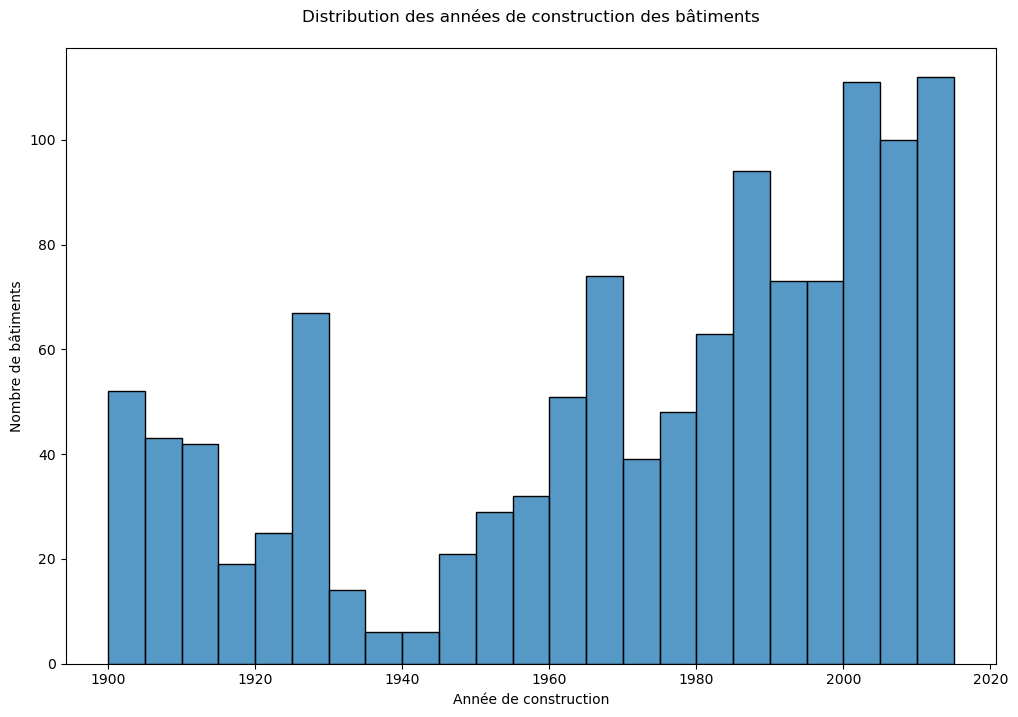

In [79]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=data, x='YearBuilt', bins=int((data.YearBuilt.max() - data.YearBuilt.min())/5))
ax.set_xlabel("Année de construction")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n")
plt.show()

- Plus que l'année de construction, il serait intéressant de traiter l'âge des bâtiments

In [80]:
data['âge']=2016 - data.YearBuilt

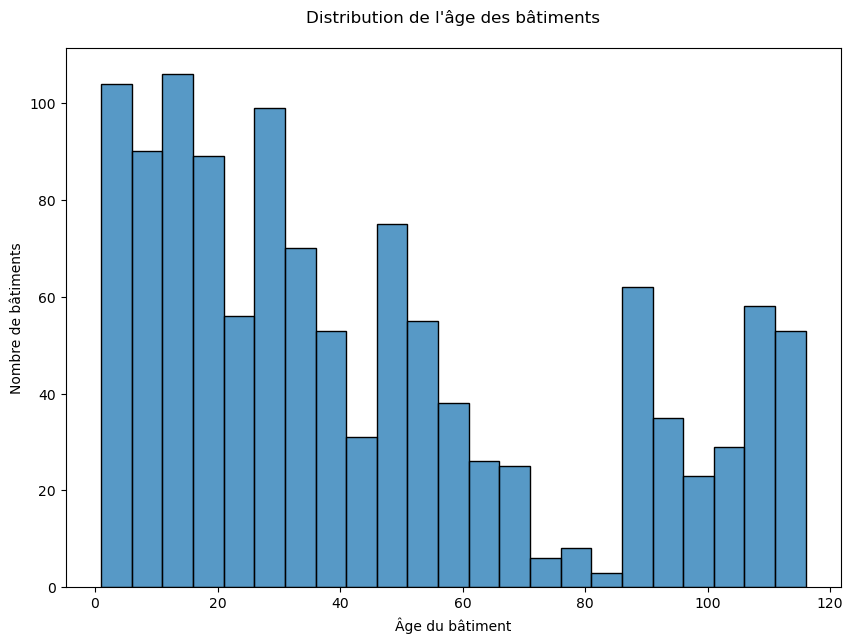

In [81]:
fig = plt.figure(figsize=(10,7))
ax = sns.histplot(data=data, x='âge', bins=int((data.âge.max() - data.âge.min())/5))
ax.set_xlabel("Âge du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution de l'âge des bâtiments\n")
plt.show()

#### ENERGYSTARScore
#### Exploration
#### Analyse univariée
- Distribution des données

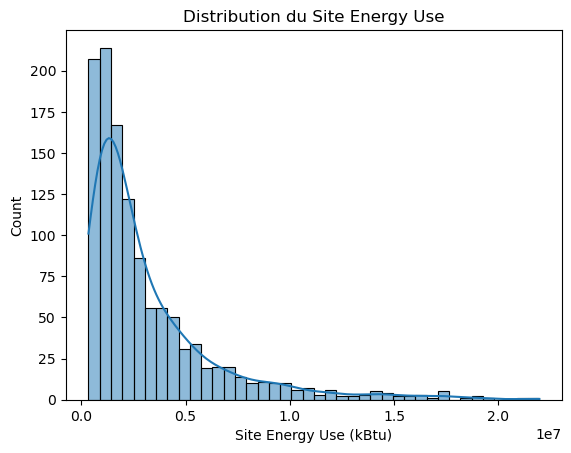

In [82]:
# Vérifier si 'SiteEnergyUseWN(kBtu)' contient des valeurs manquantes et les supprimer
data_cleaned = data.dropna(subset=['SiteEnergyUseWN(kBtu)'])

# Tracer le graphique de distribution
sns.histplot(data_cleaned['SiteEnergyUseWN(kBtu)'], kde=True)
plt.xlabel('Site Energy Use (kBtu)')
plt.title('Distribution du Site Energy Use')
plt.show()


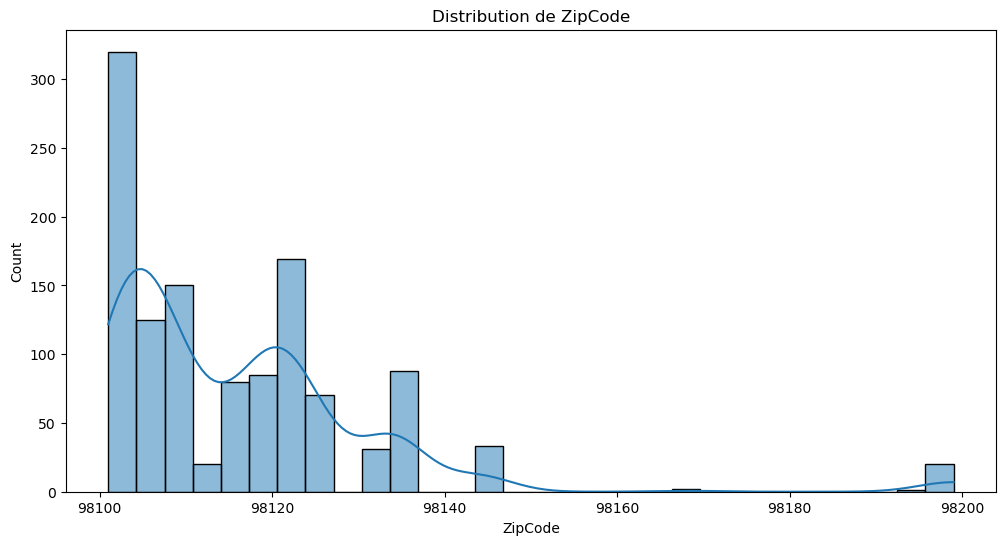

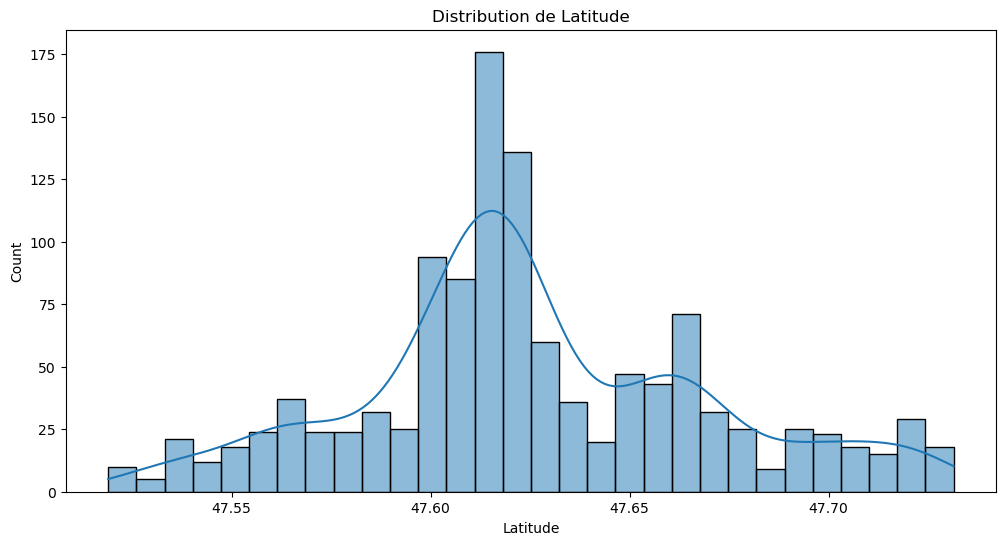

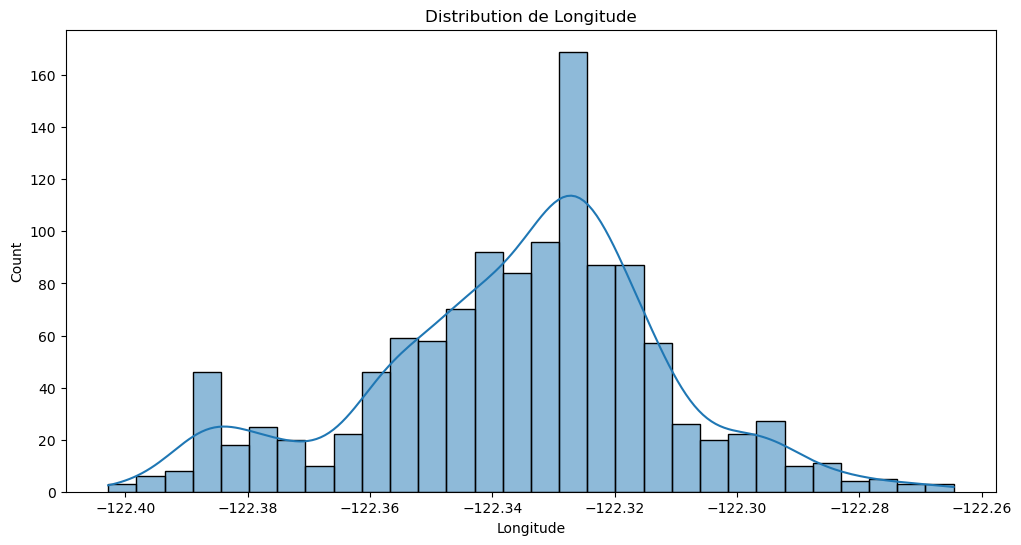

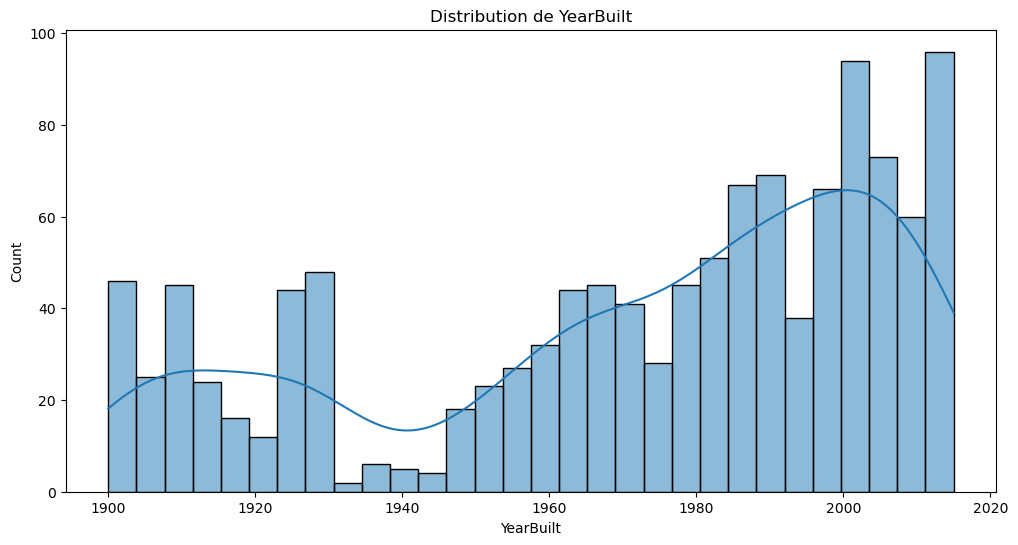

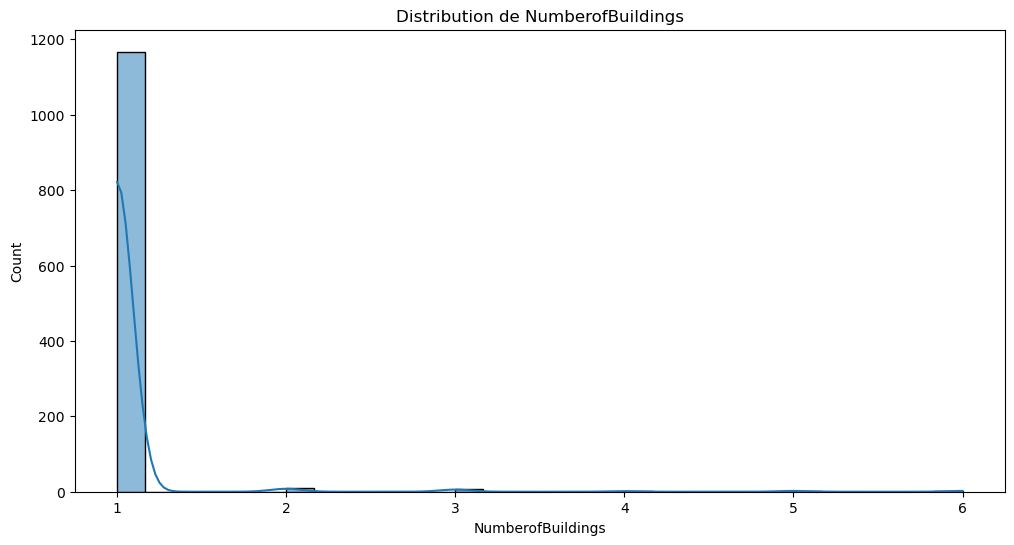

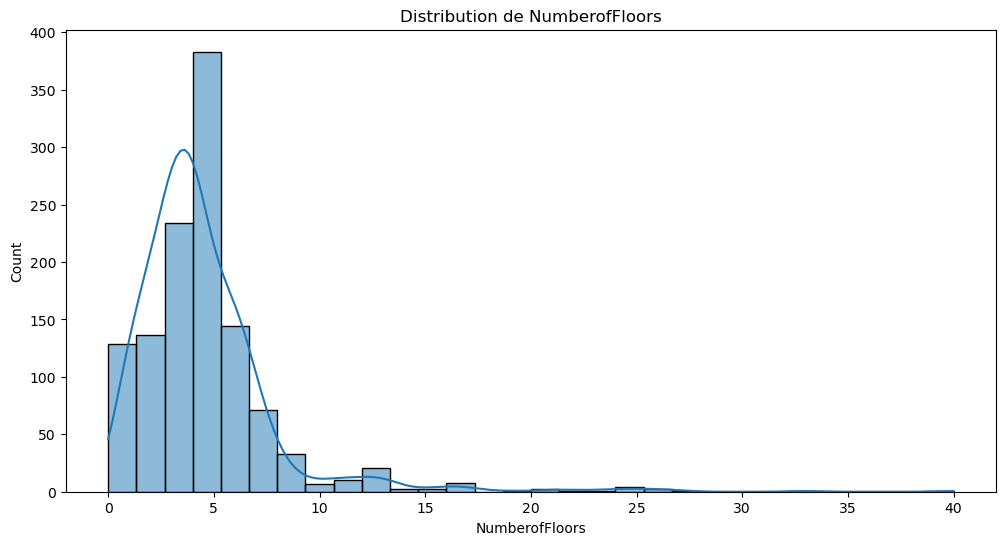

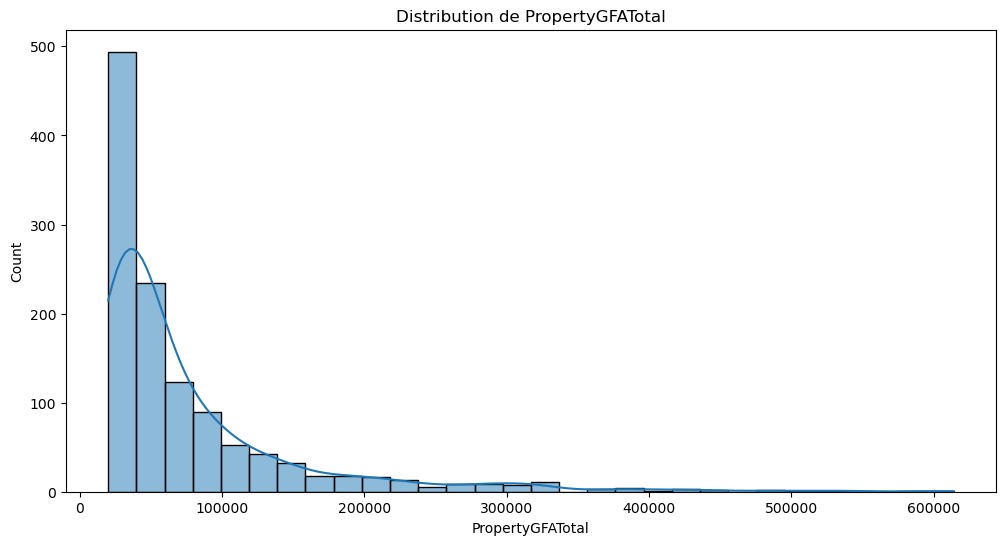

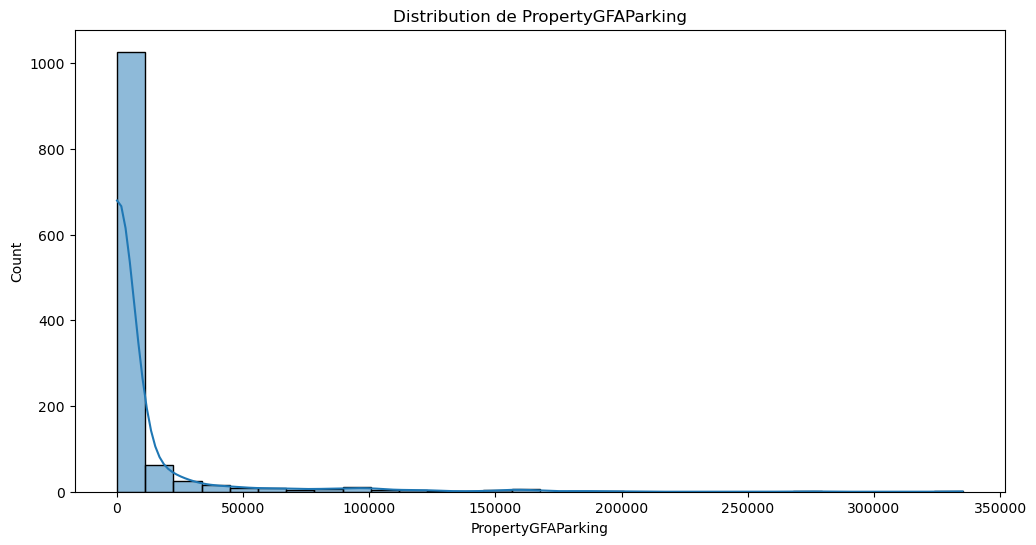

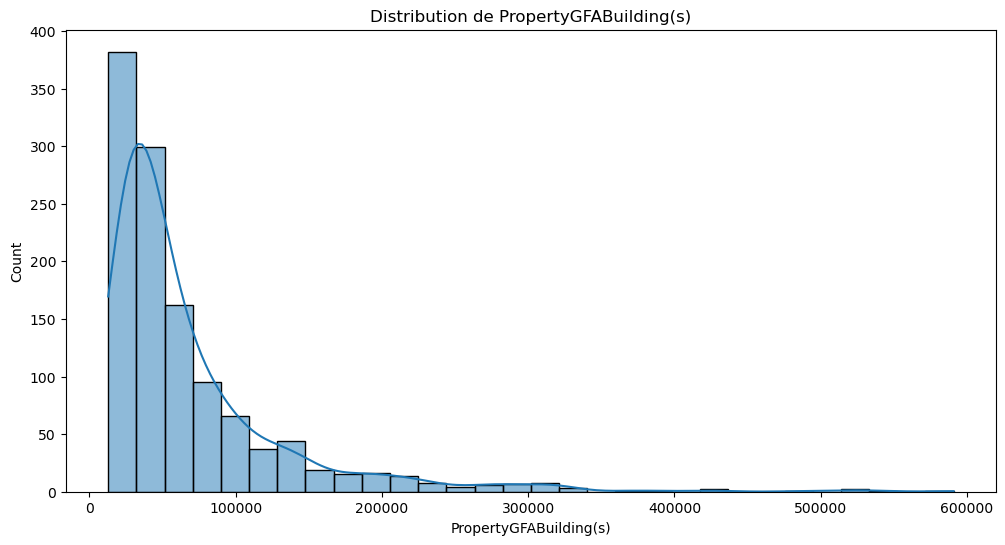

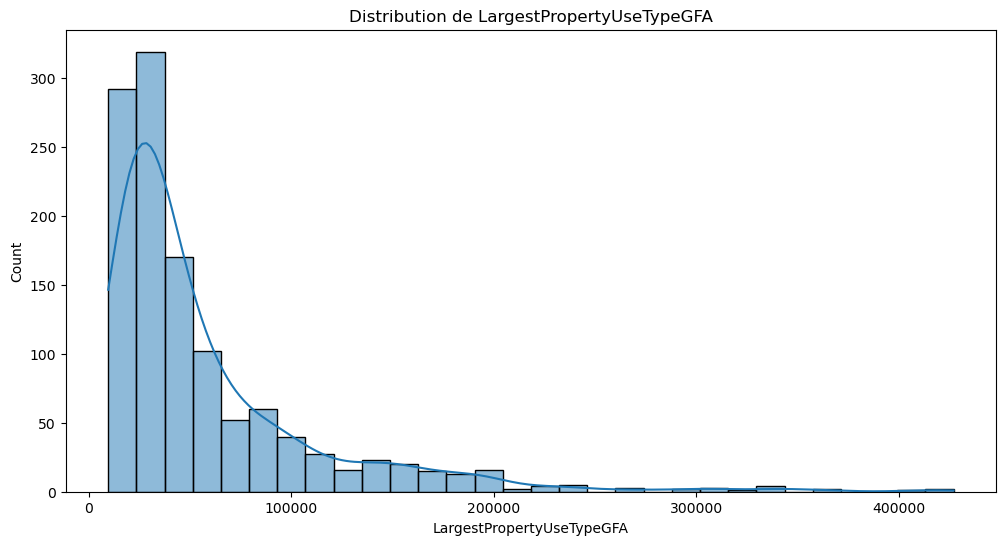

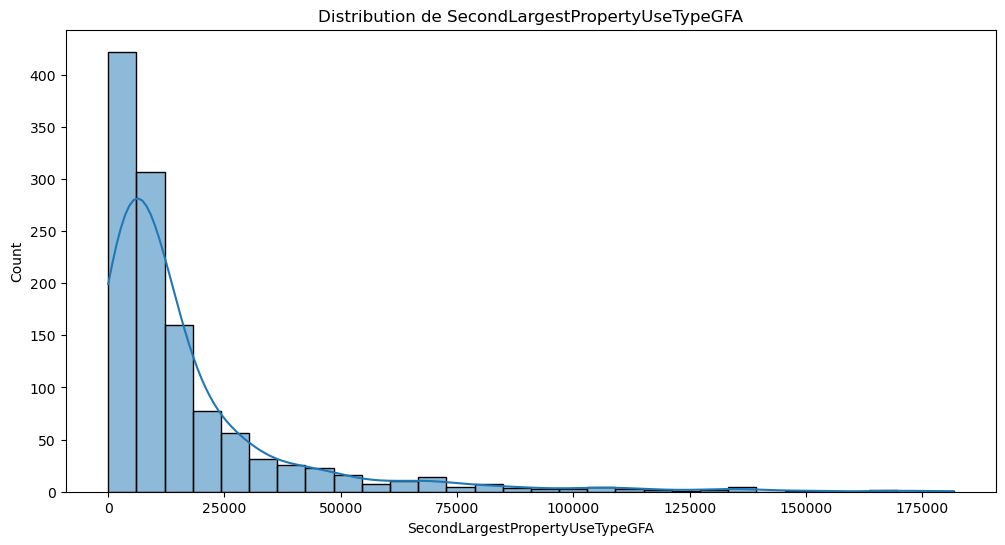

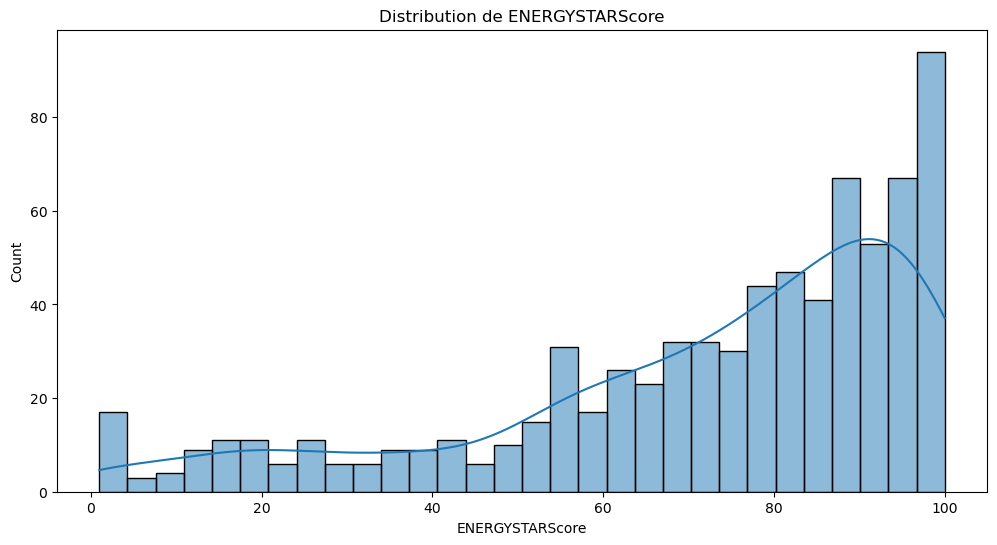

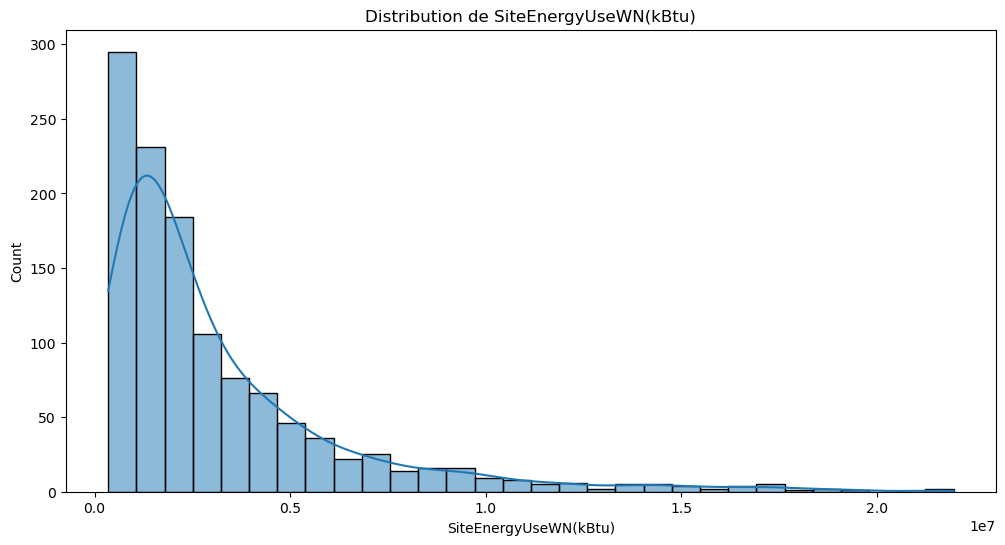

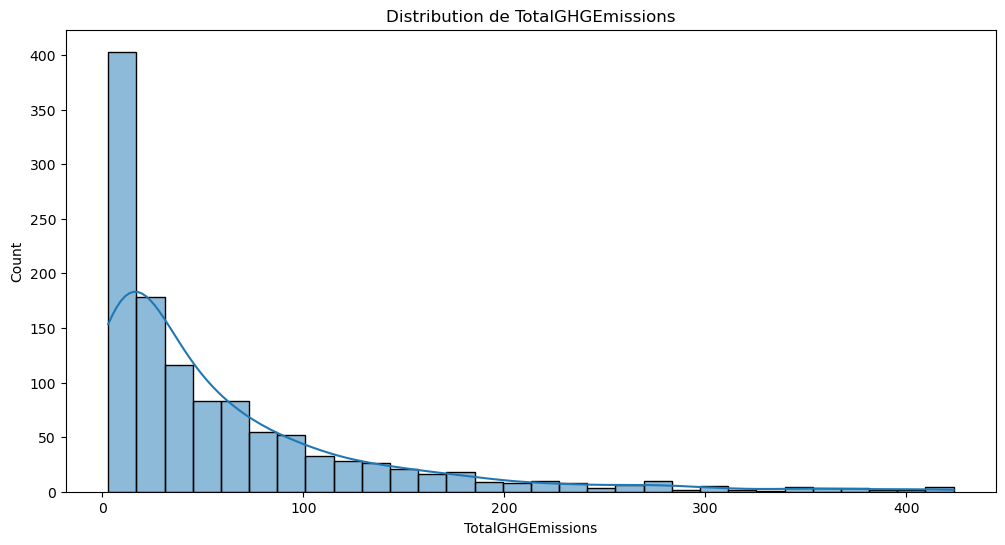

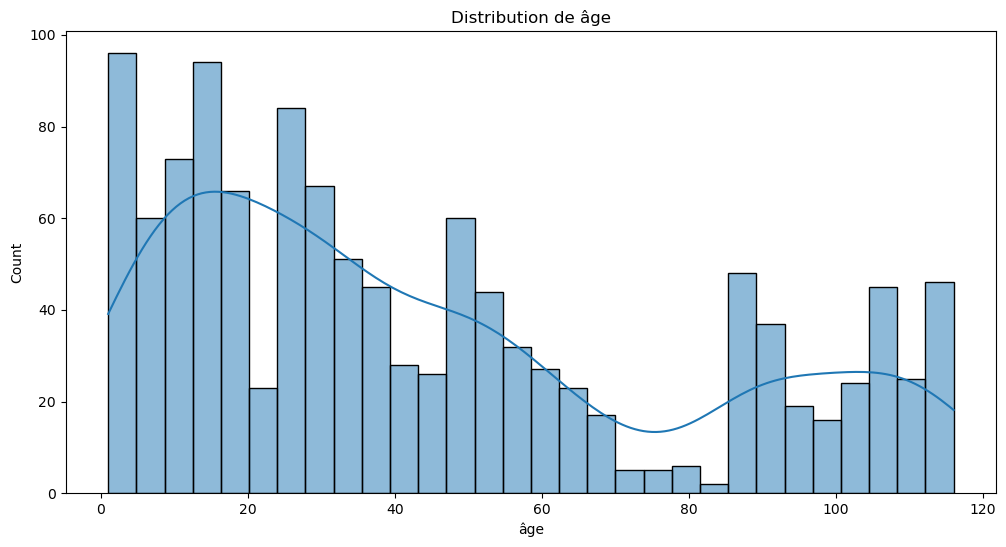

In [83]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = data.select_dtypes(['int32', 'float64']).columns

# Afficher les distributions des colonnes numériques
for column in numeric_columns:
    plt.figure(figsize=(12, 6))
    plt.title('Distribution de ' + column)
    sns.histplot(data[column].dropna(), bins=30, kde=True)  # Utiliser sns.histplot() à la place de sns.distplot()
    plt.show()


#### Histogramme des Valeurs Continues

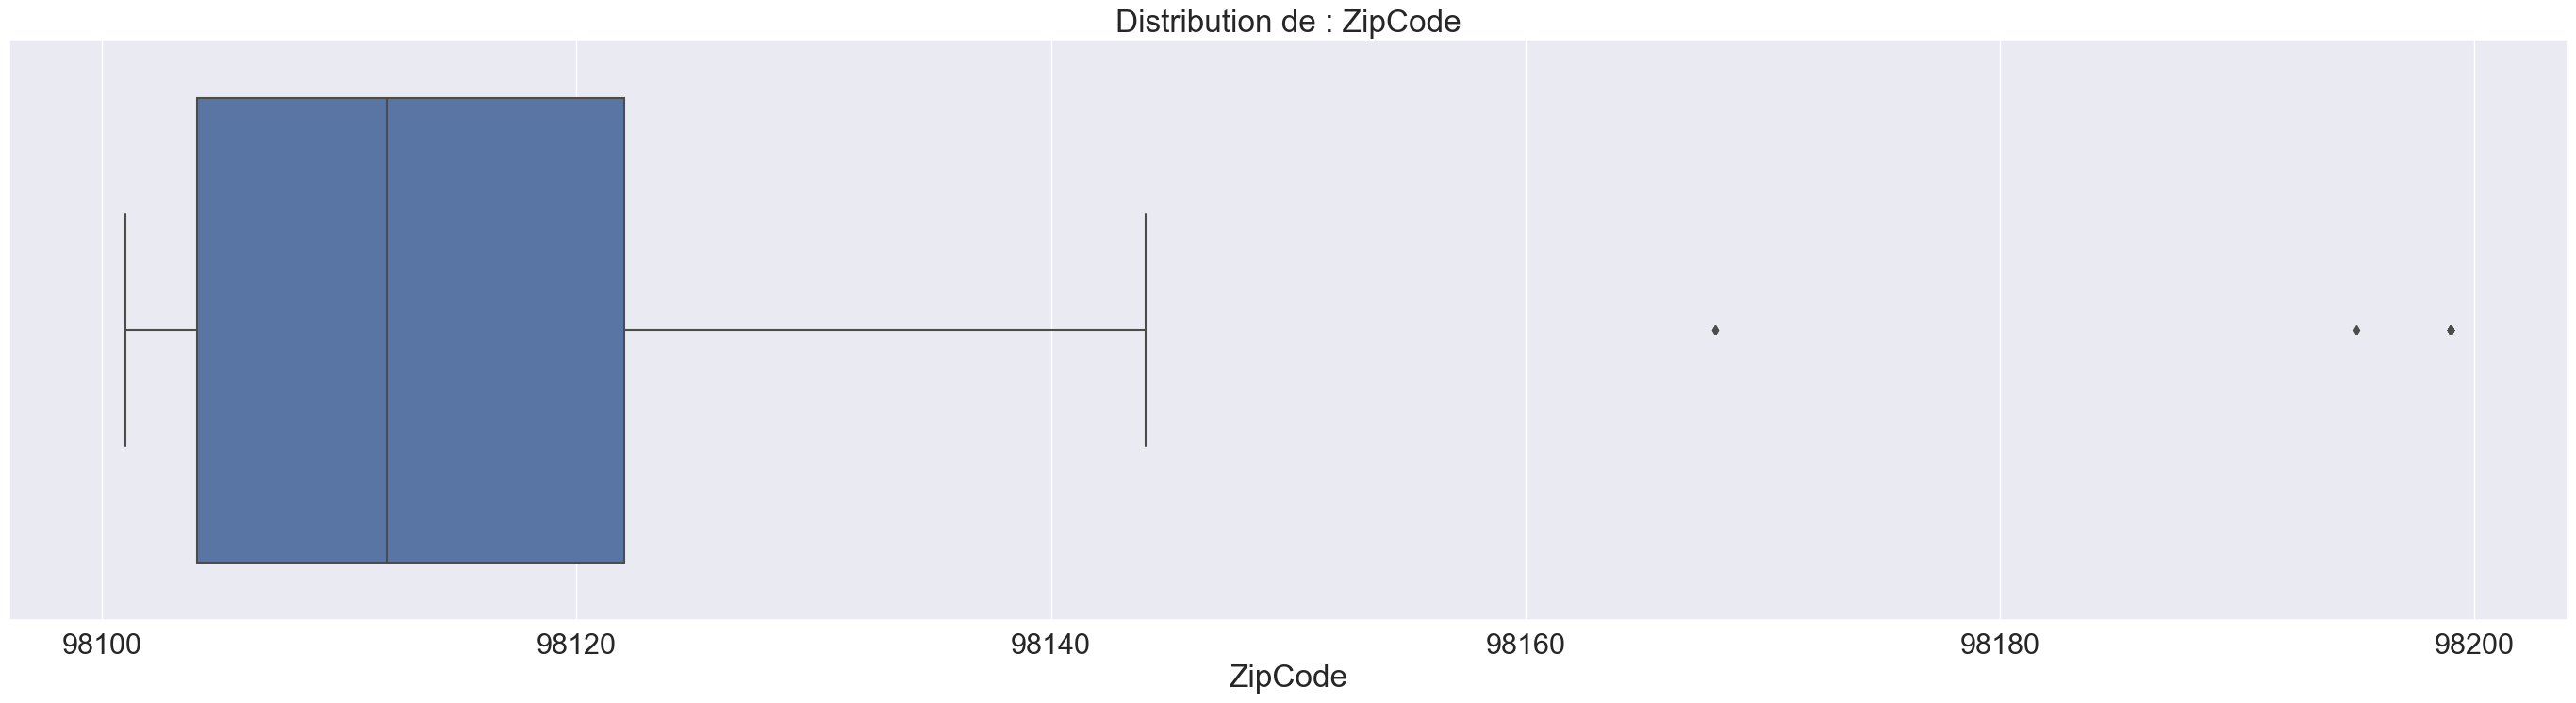

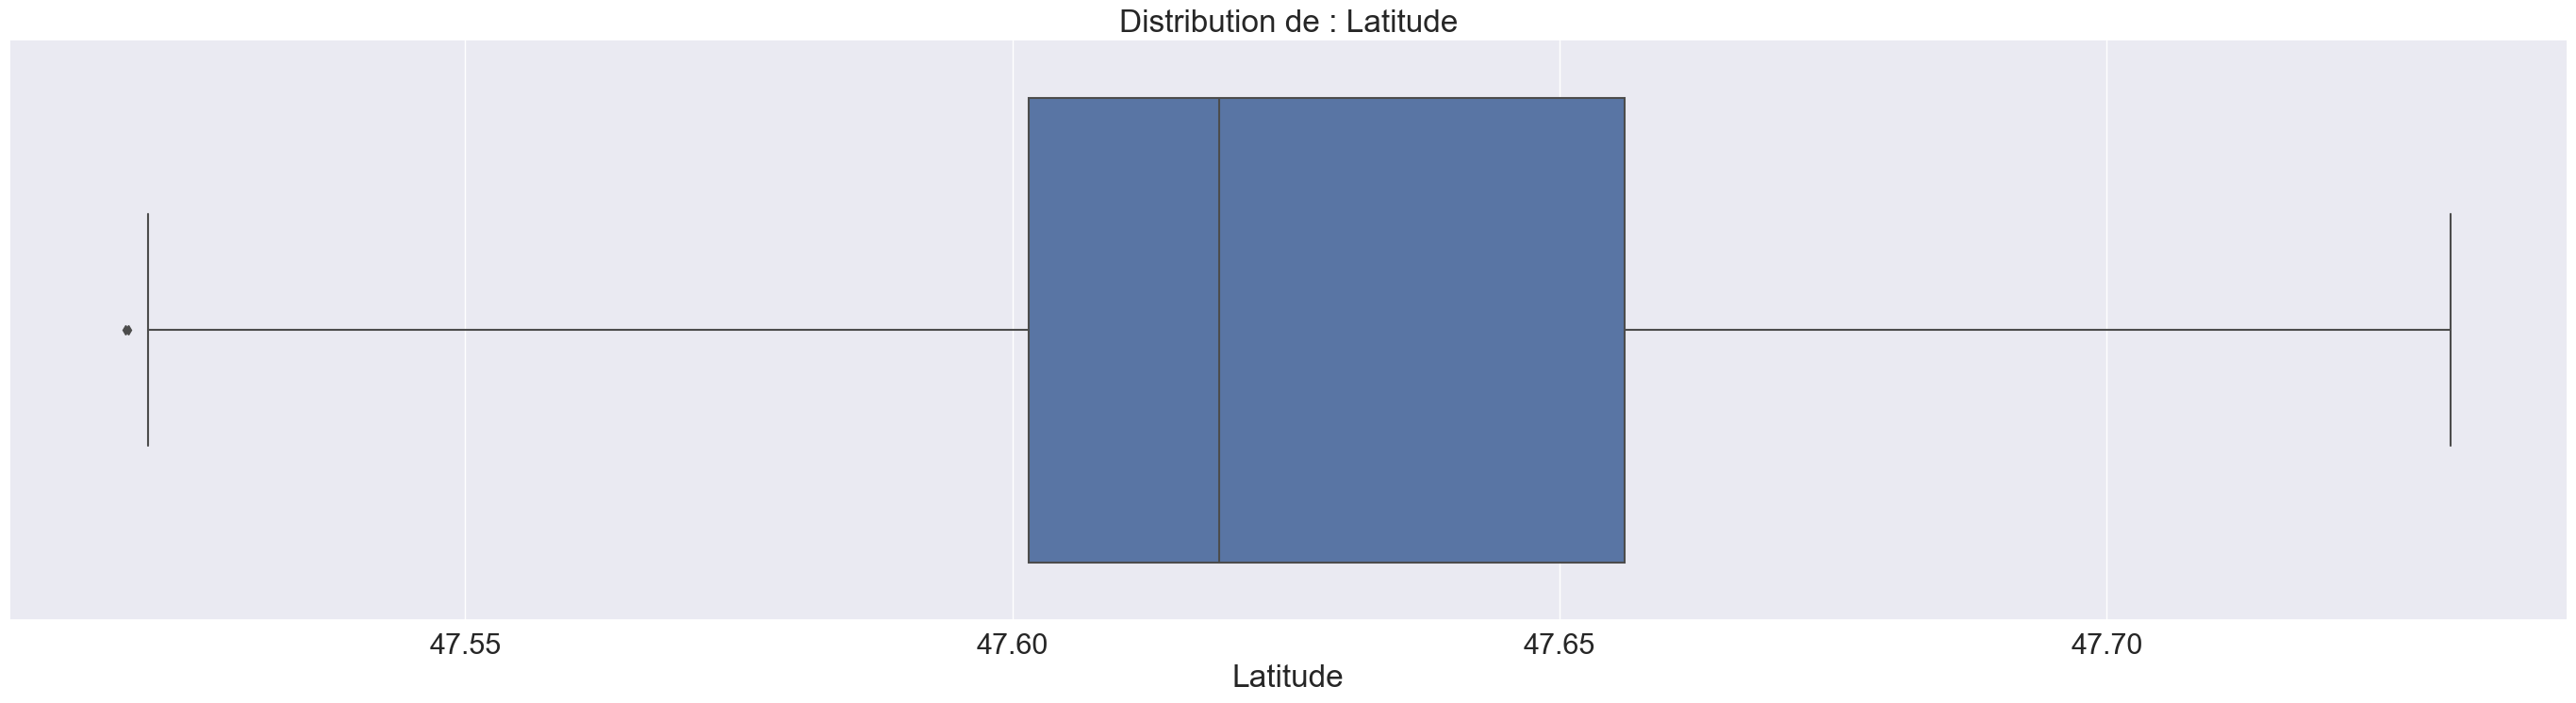

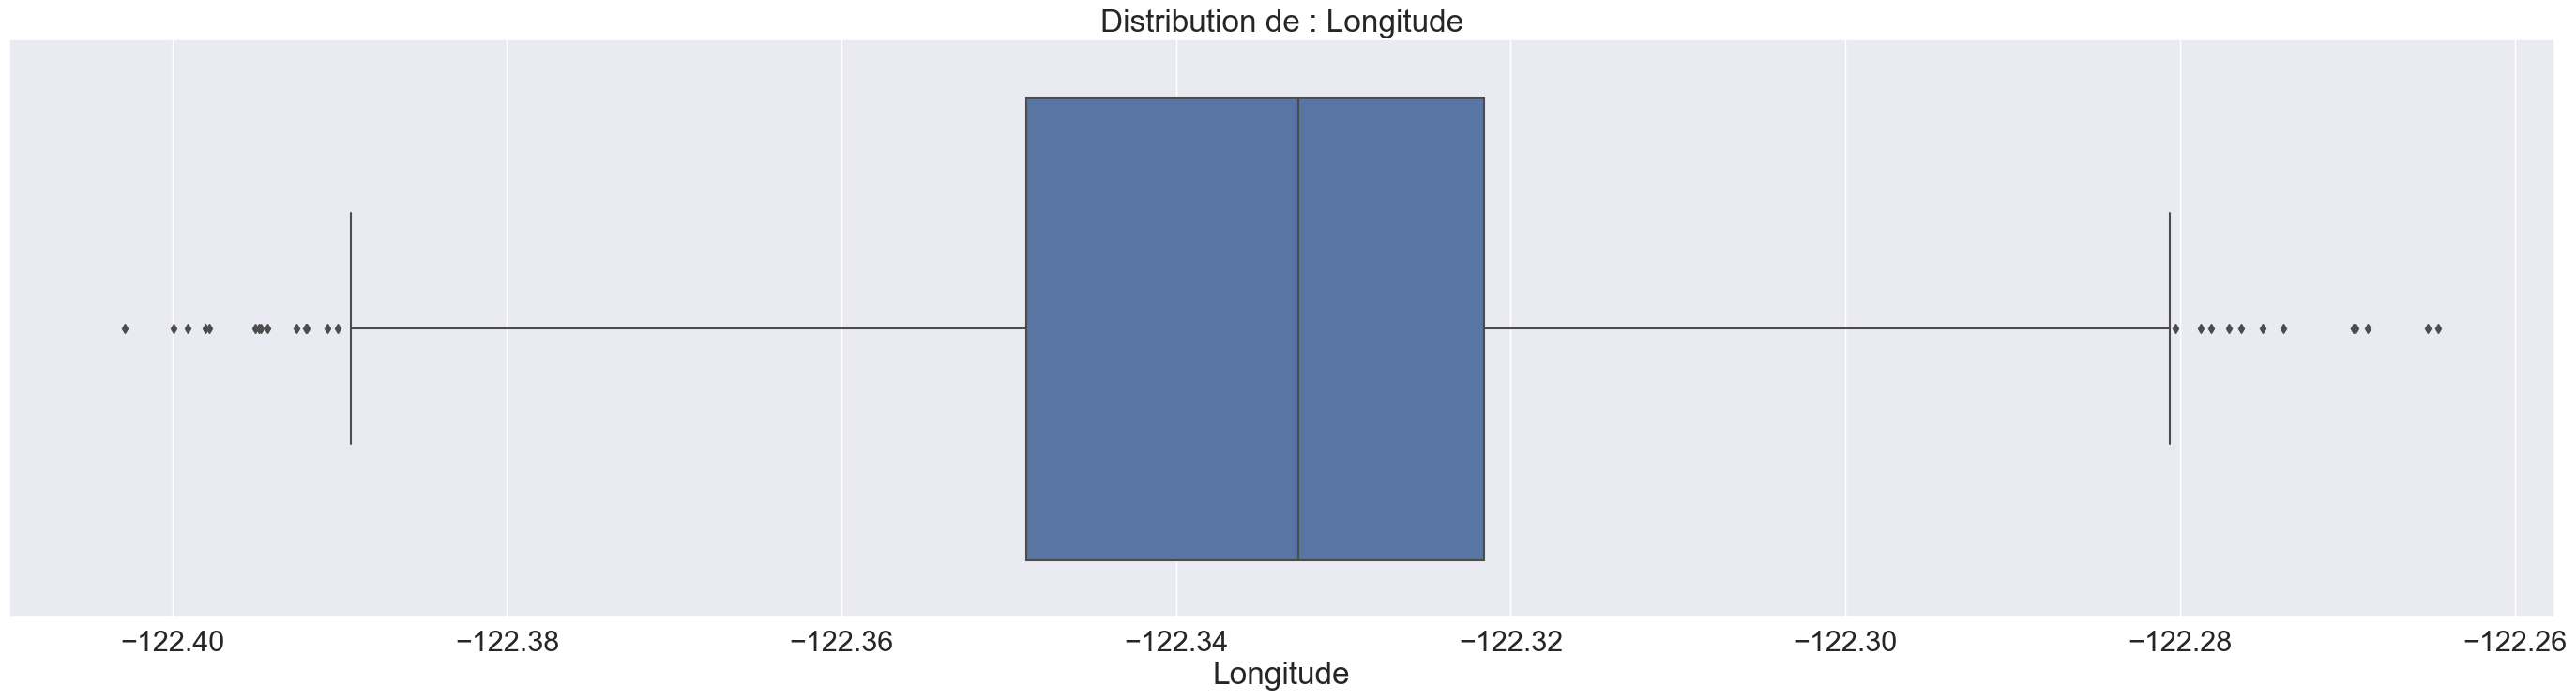

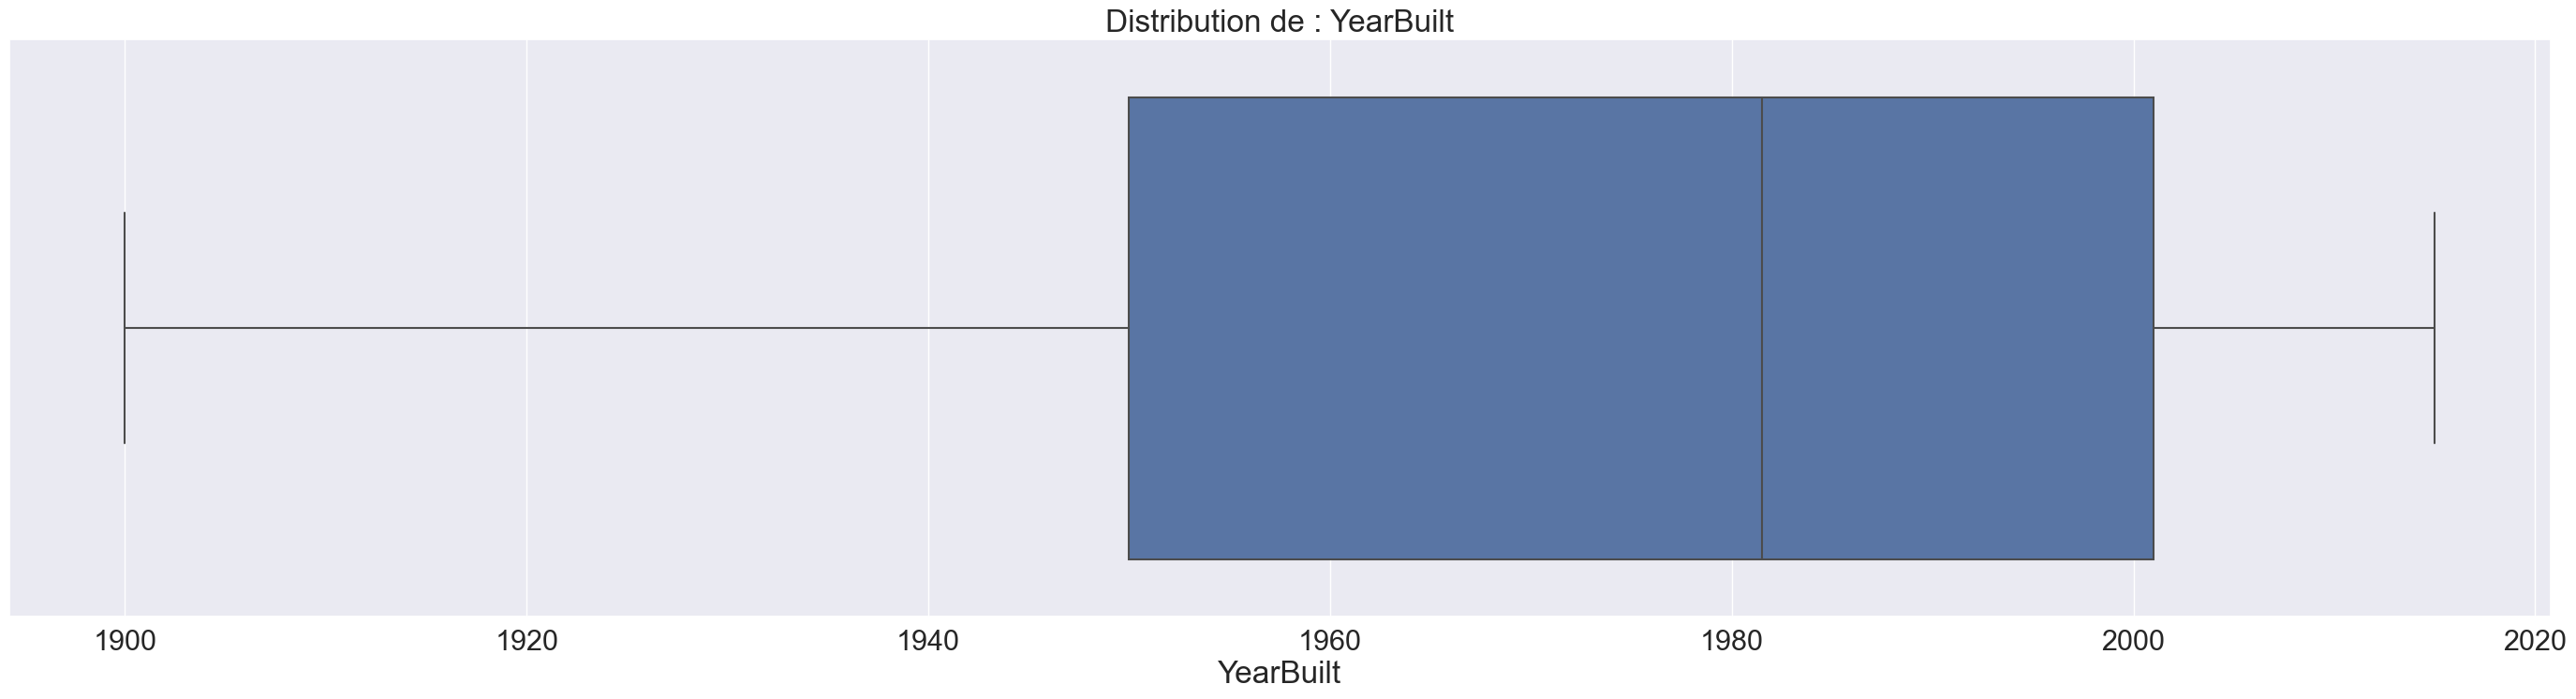

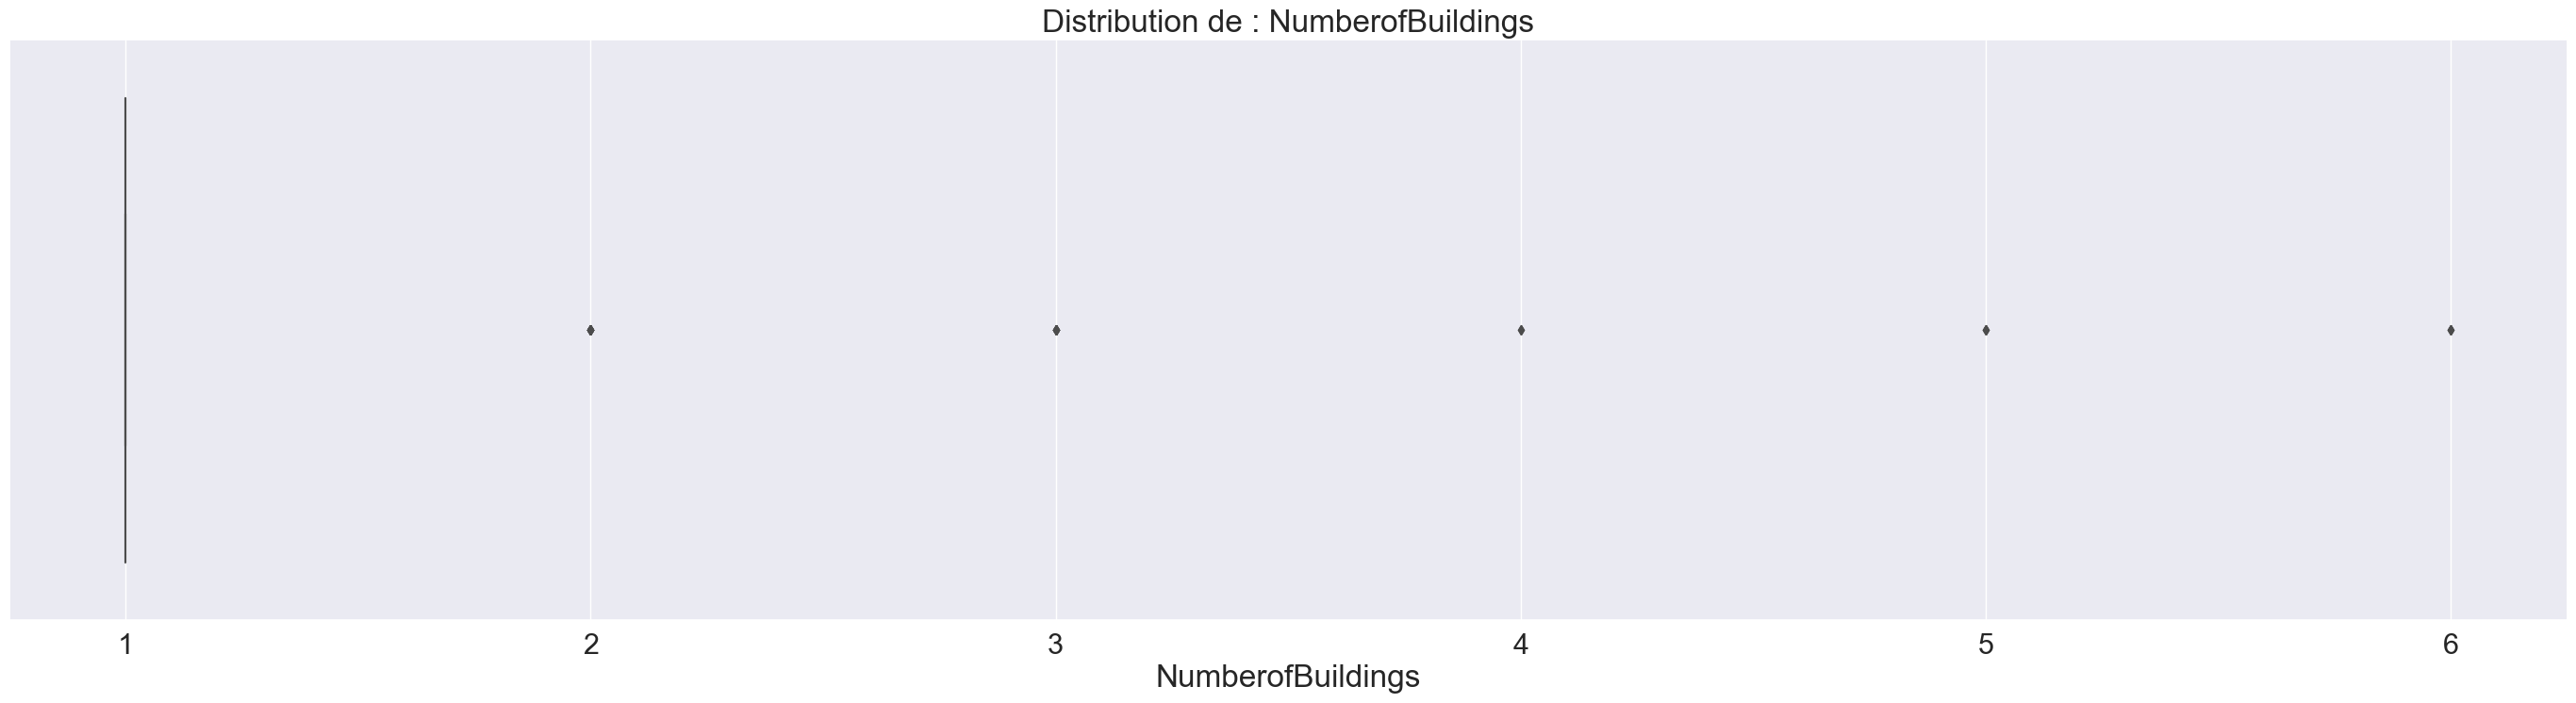

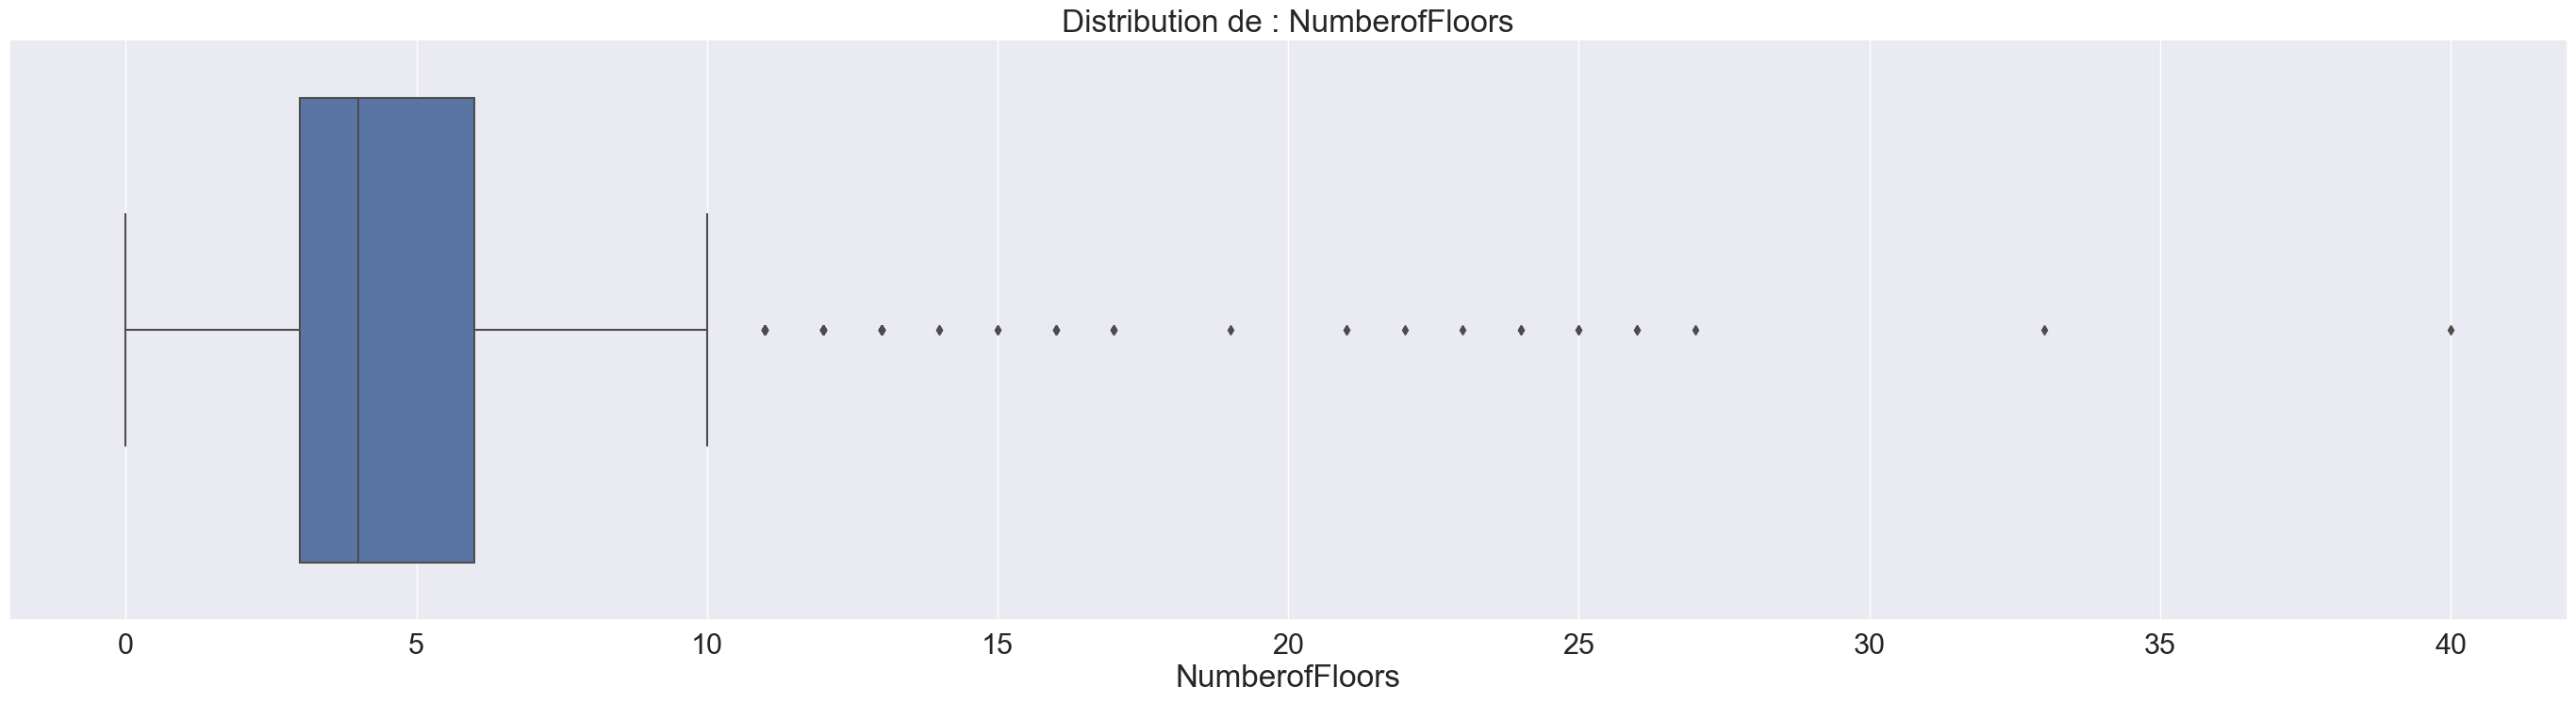

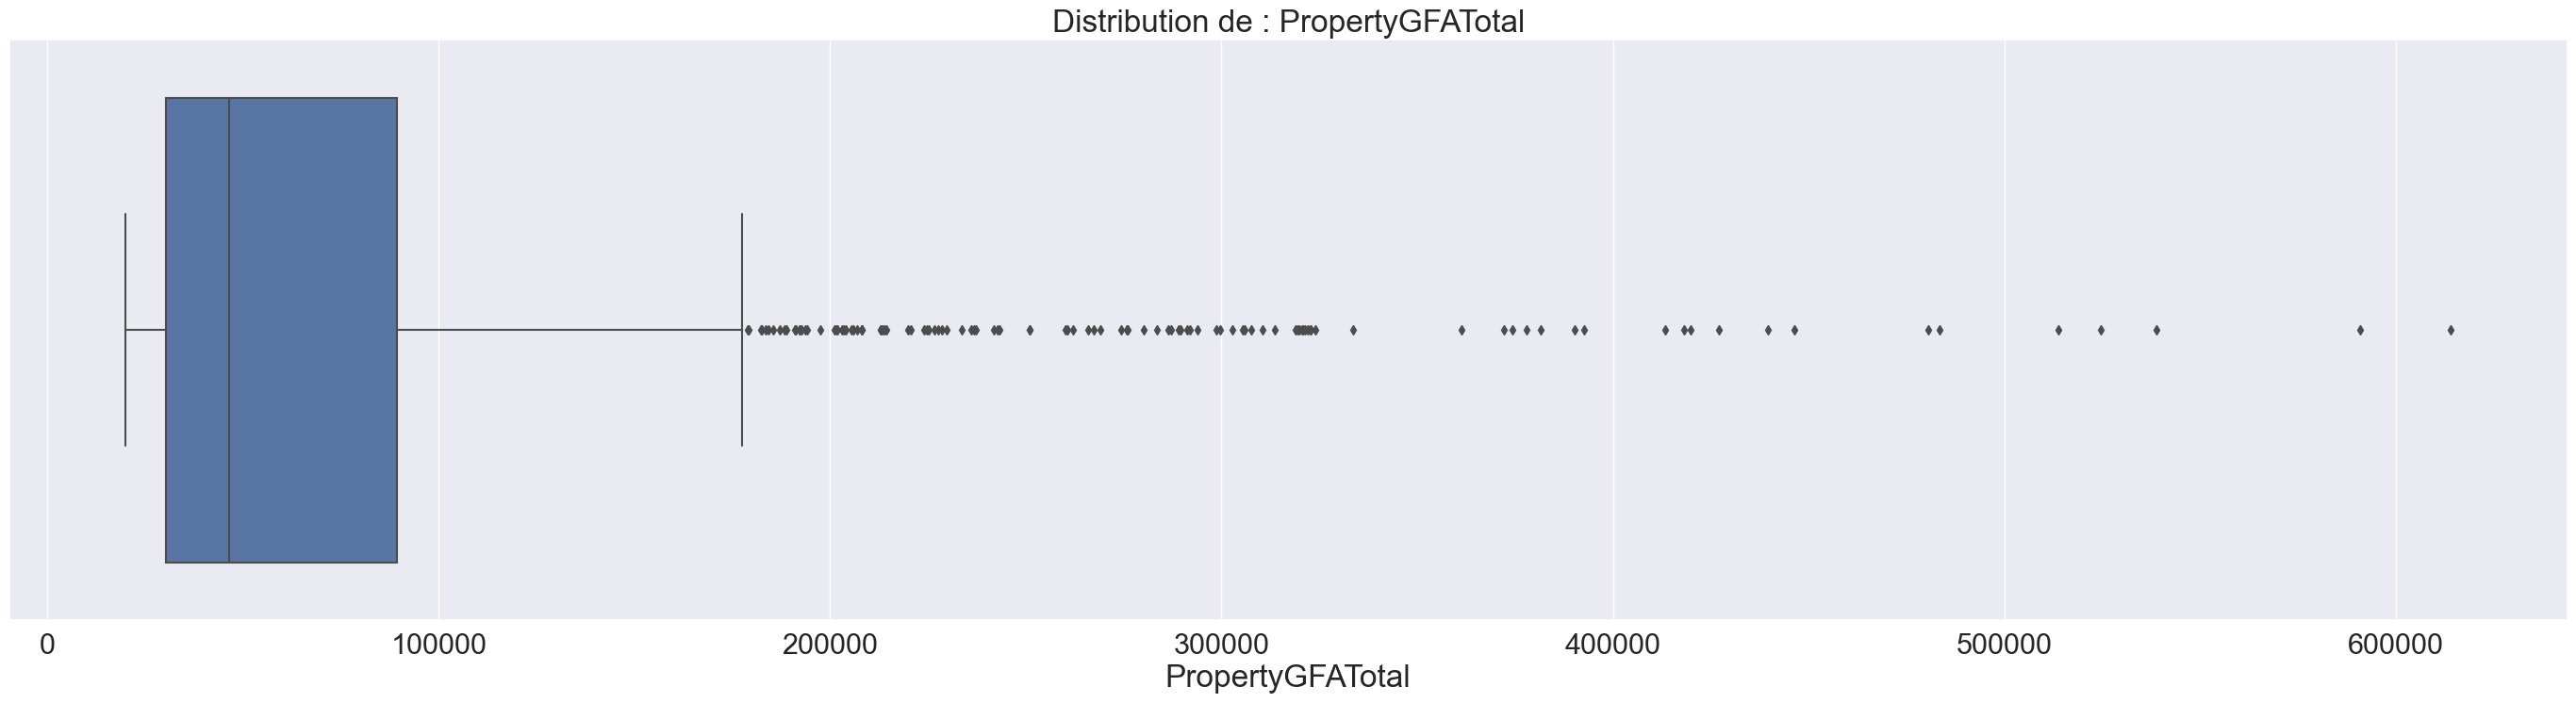

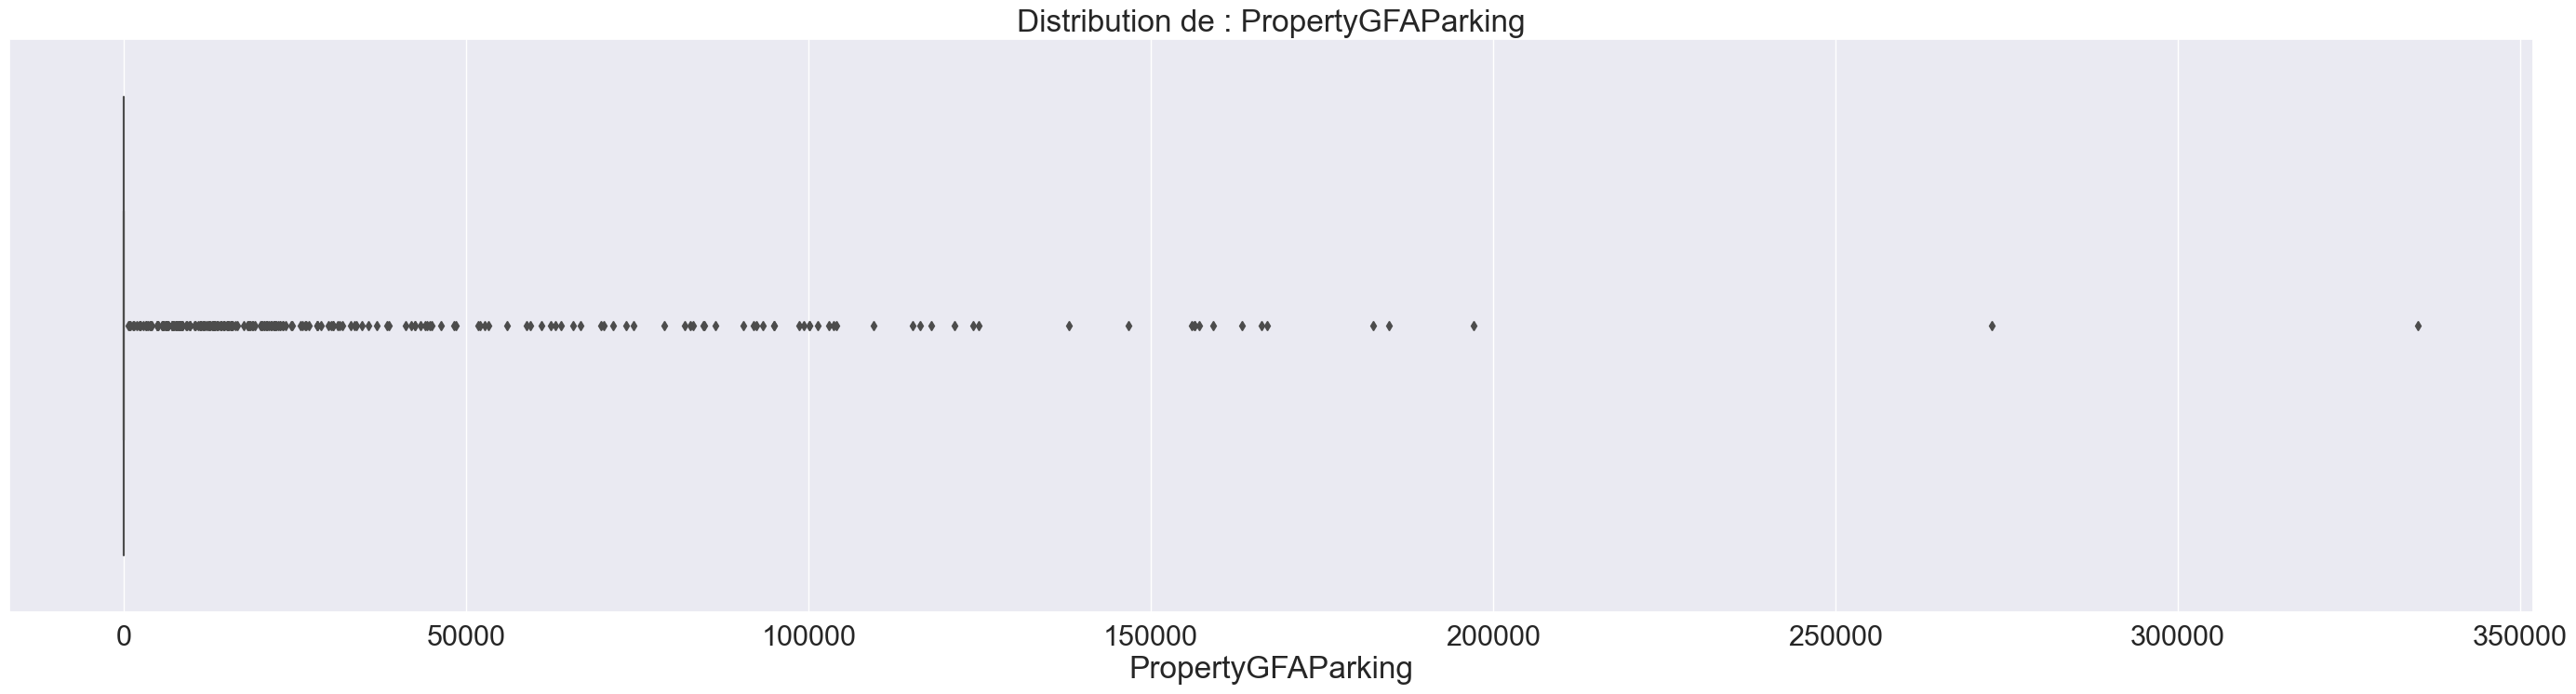

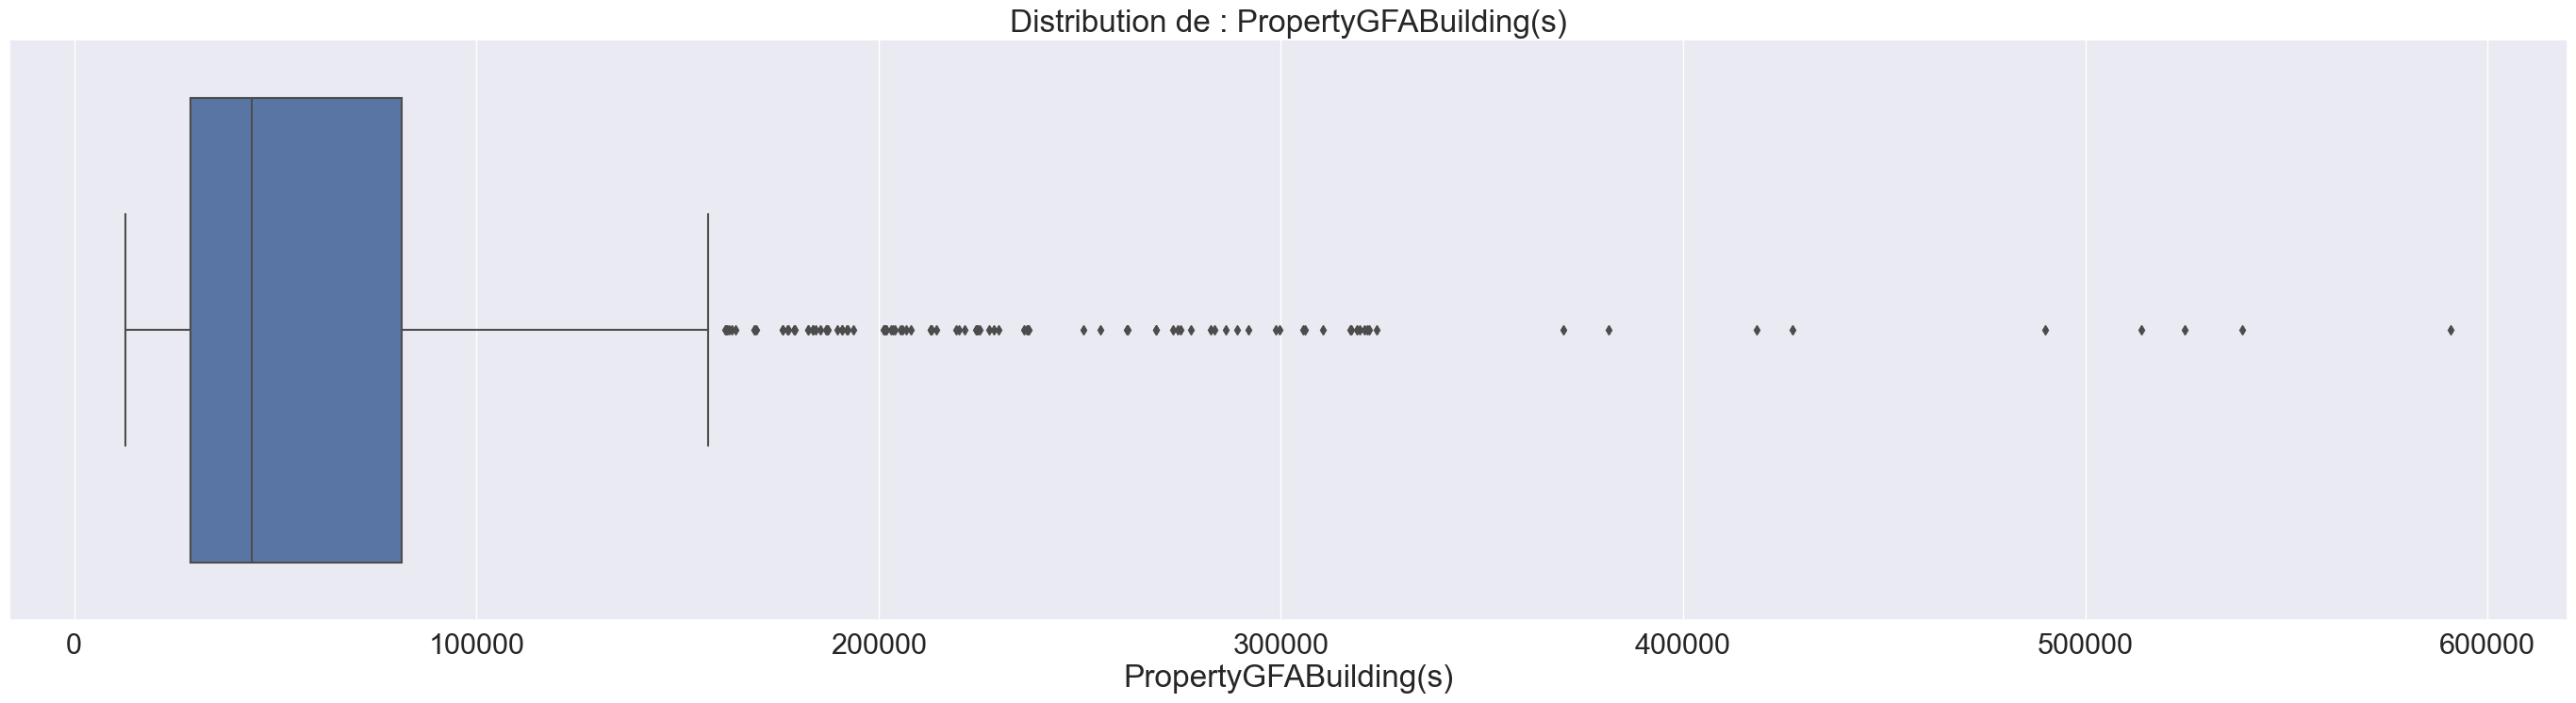

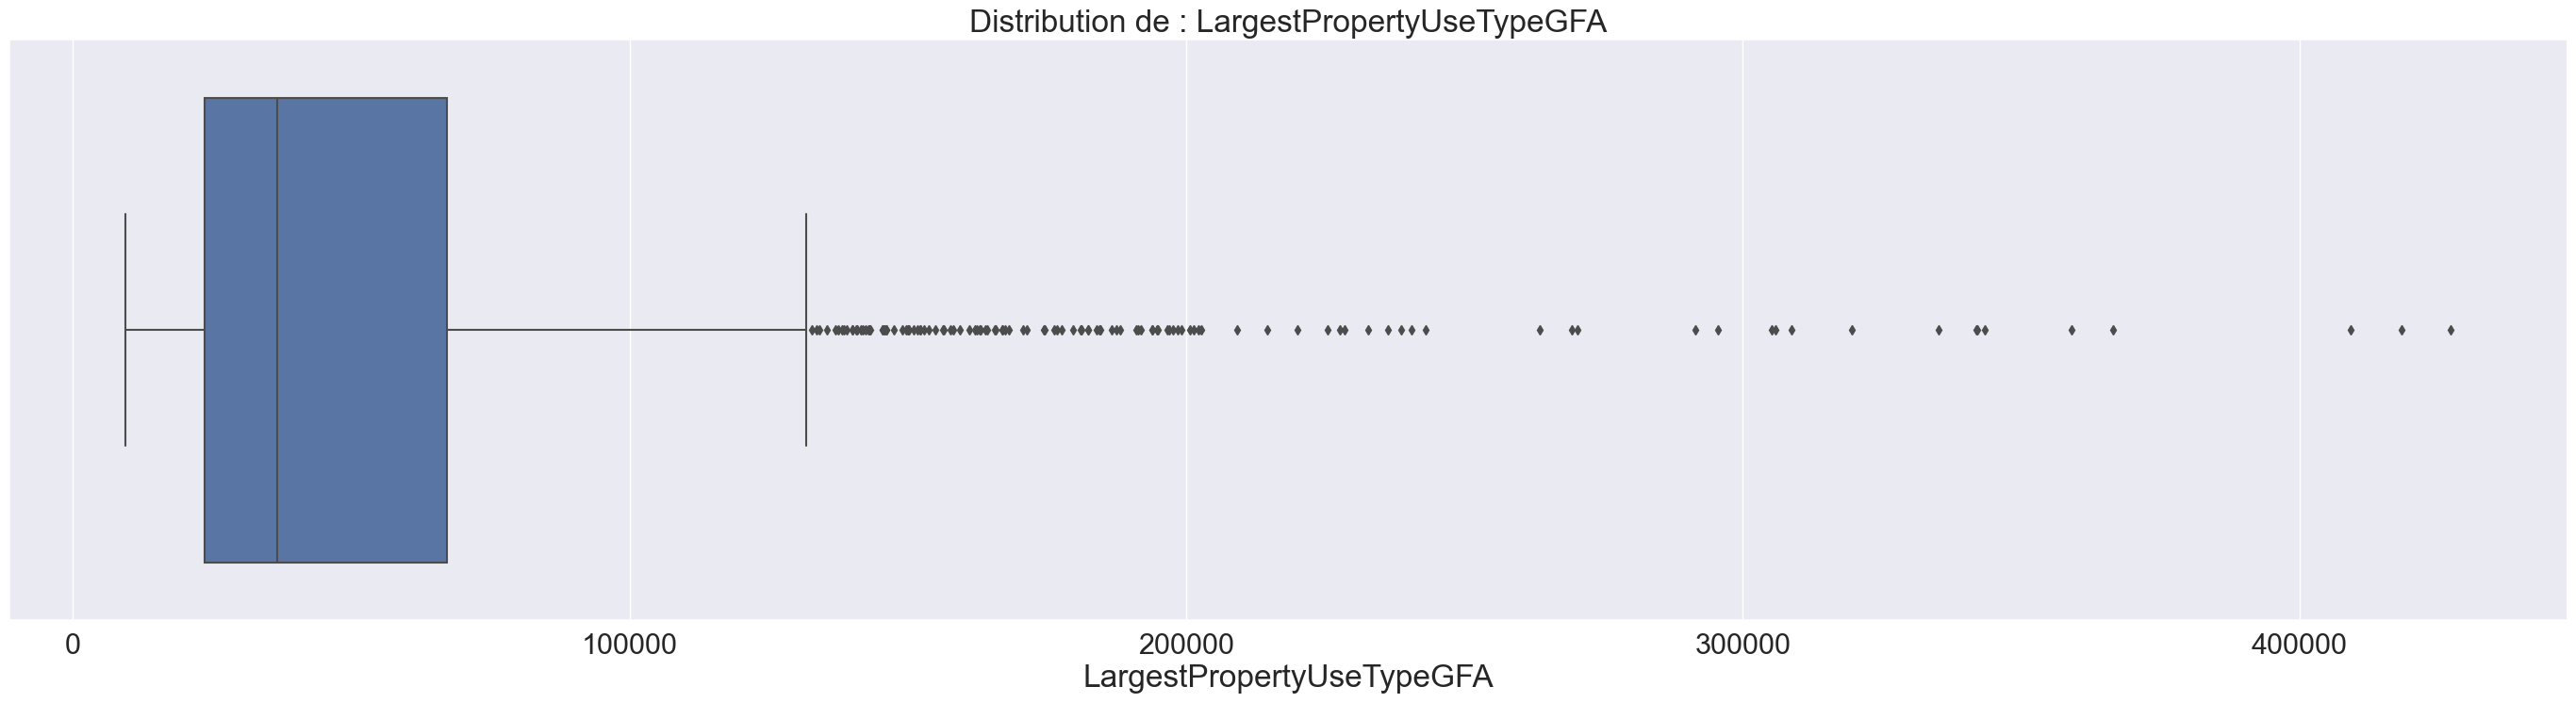

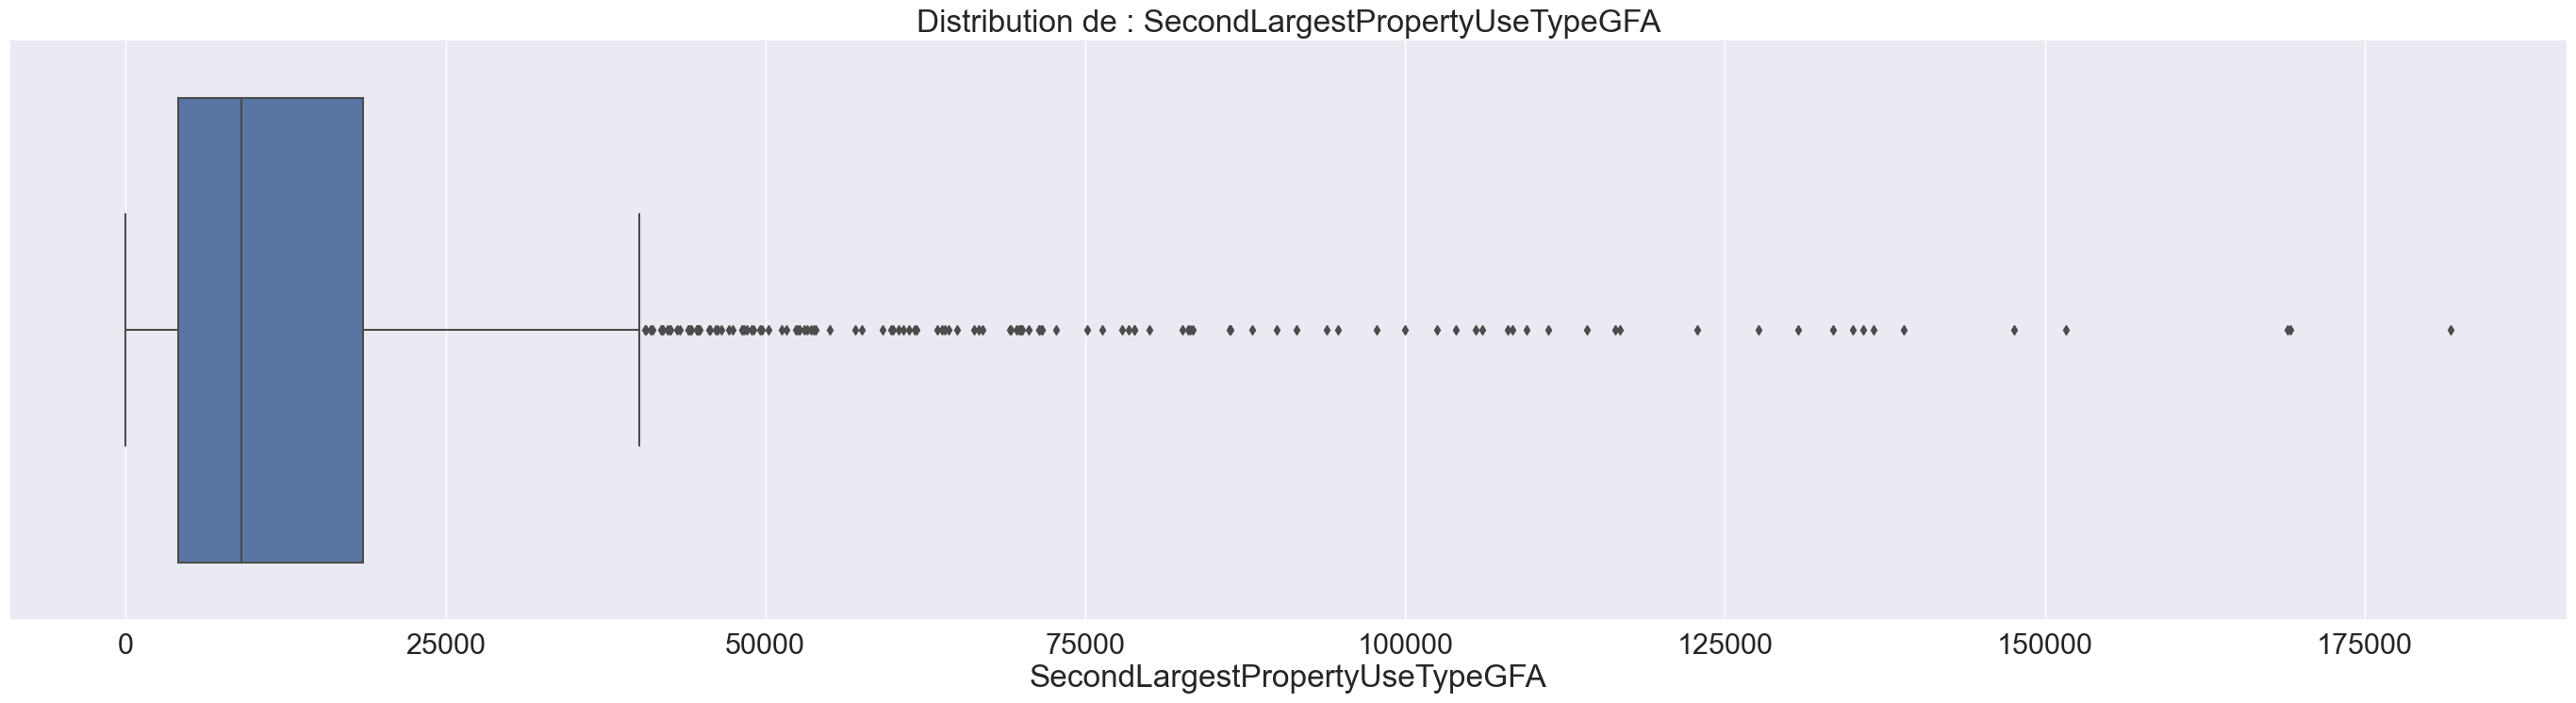

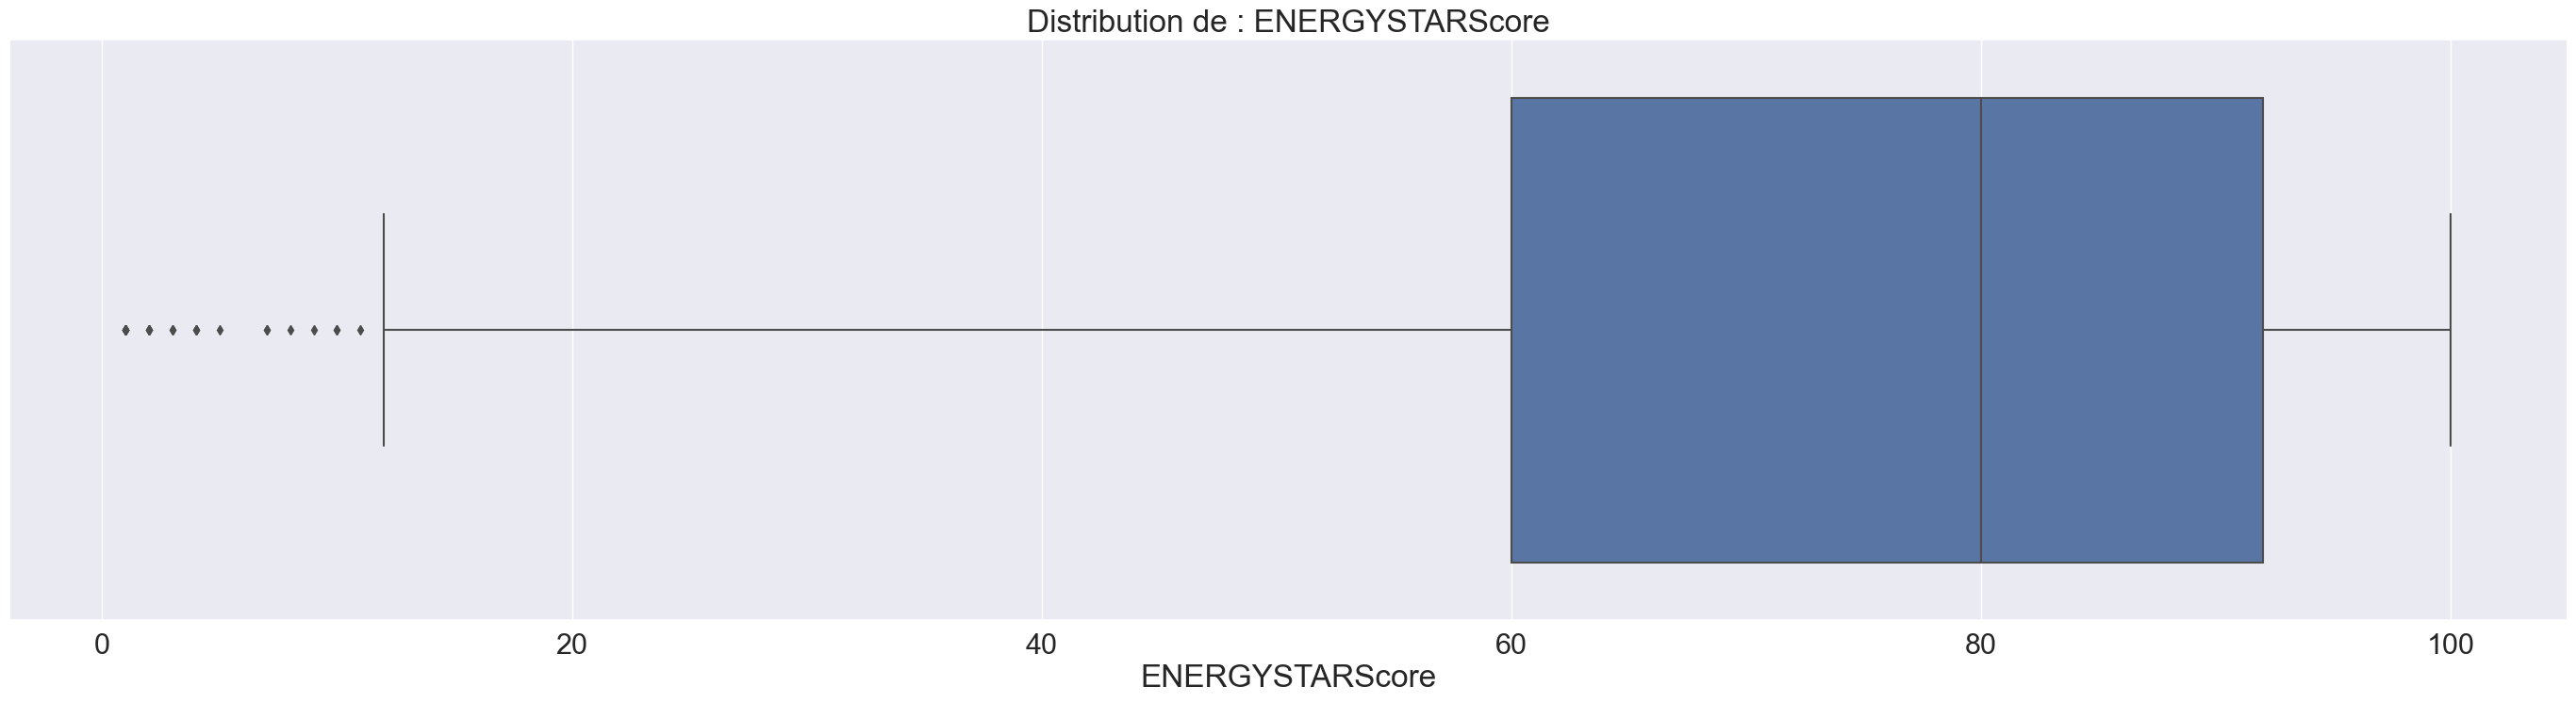

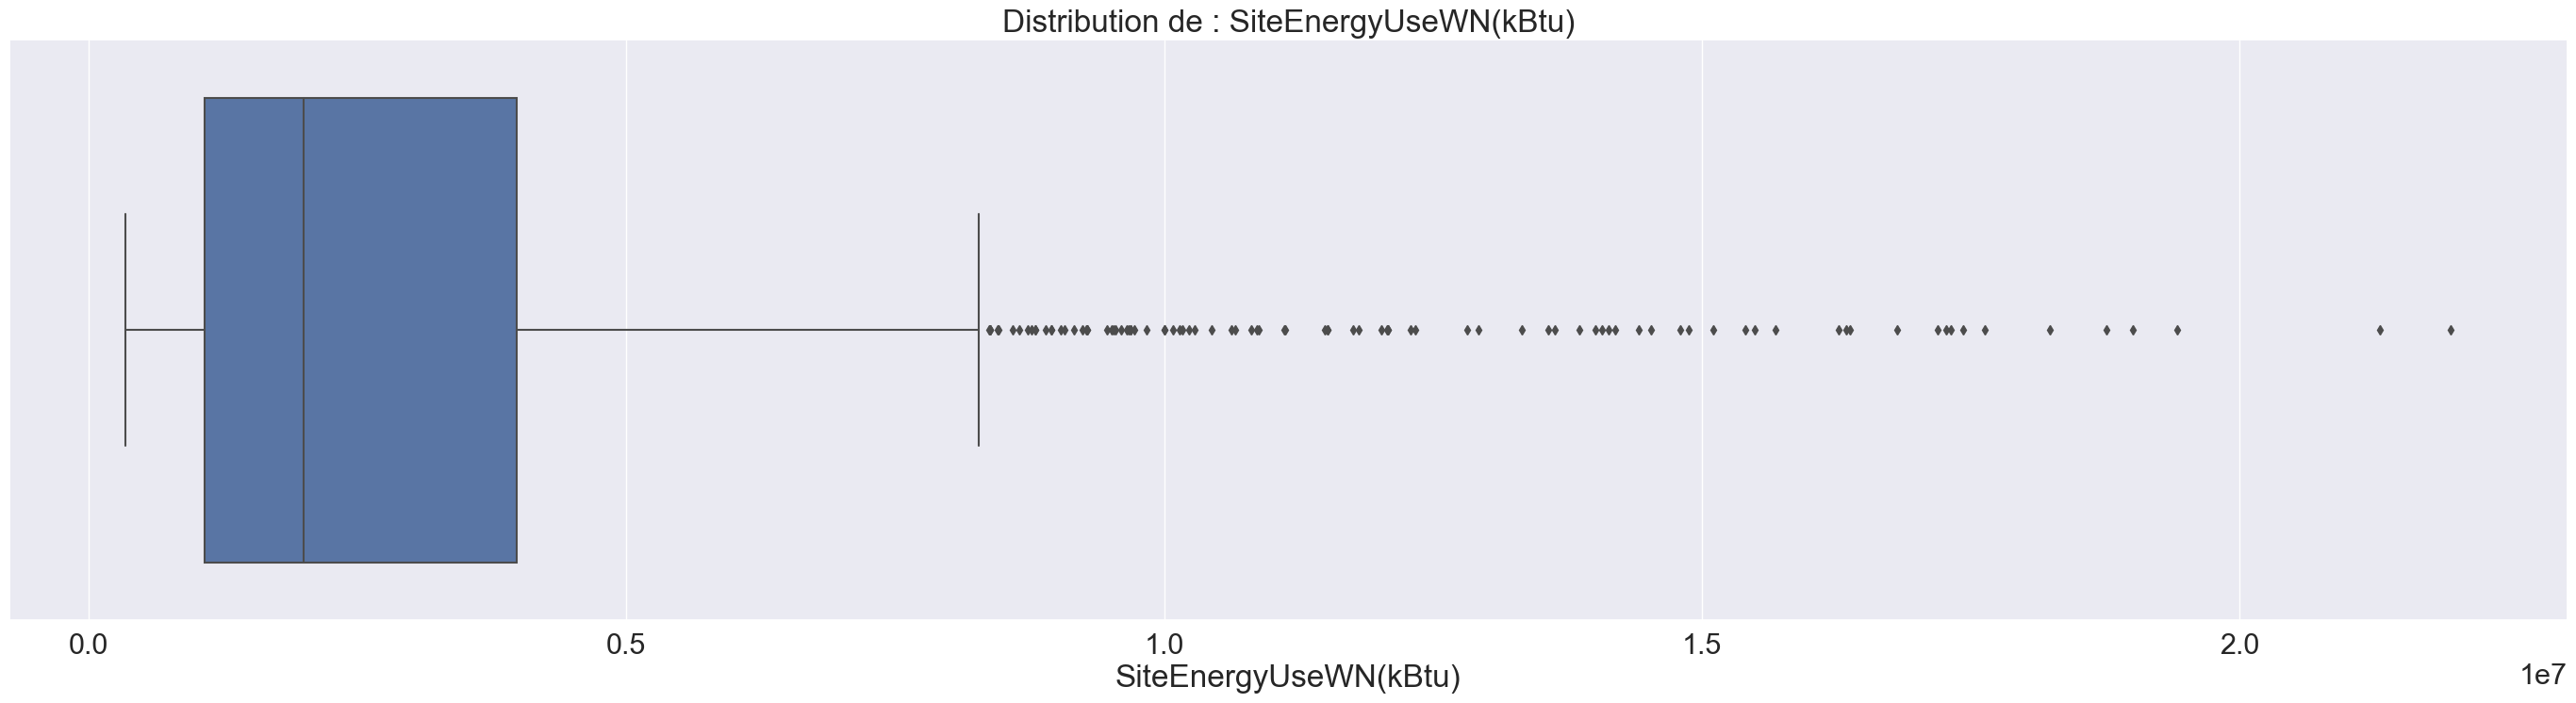

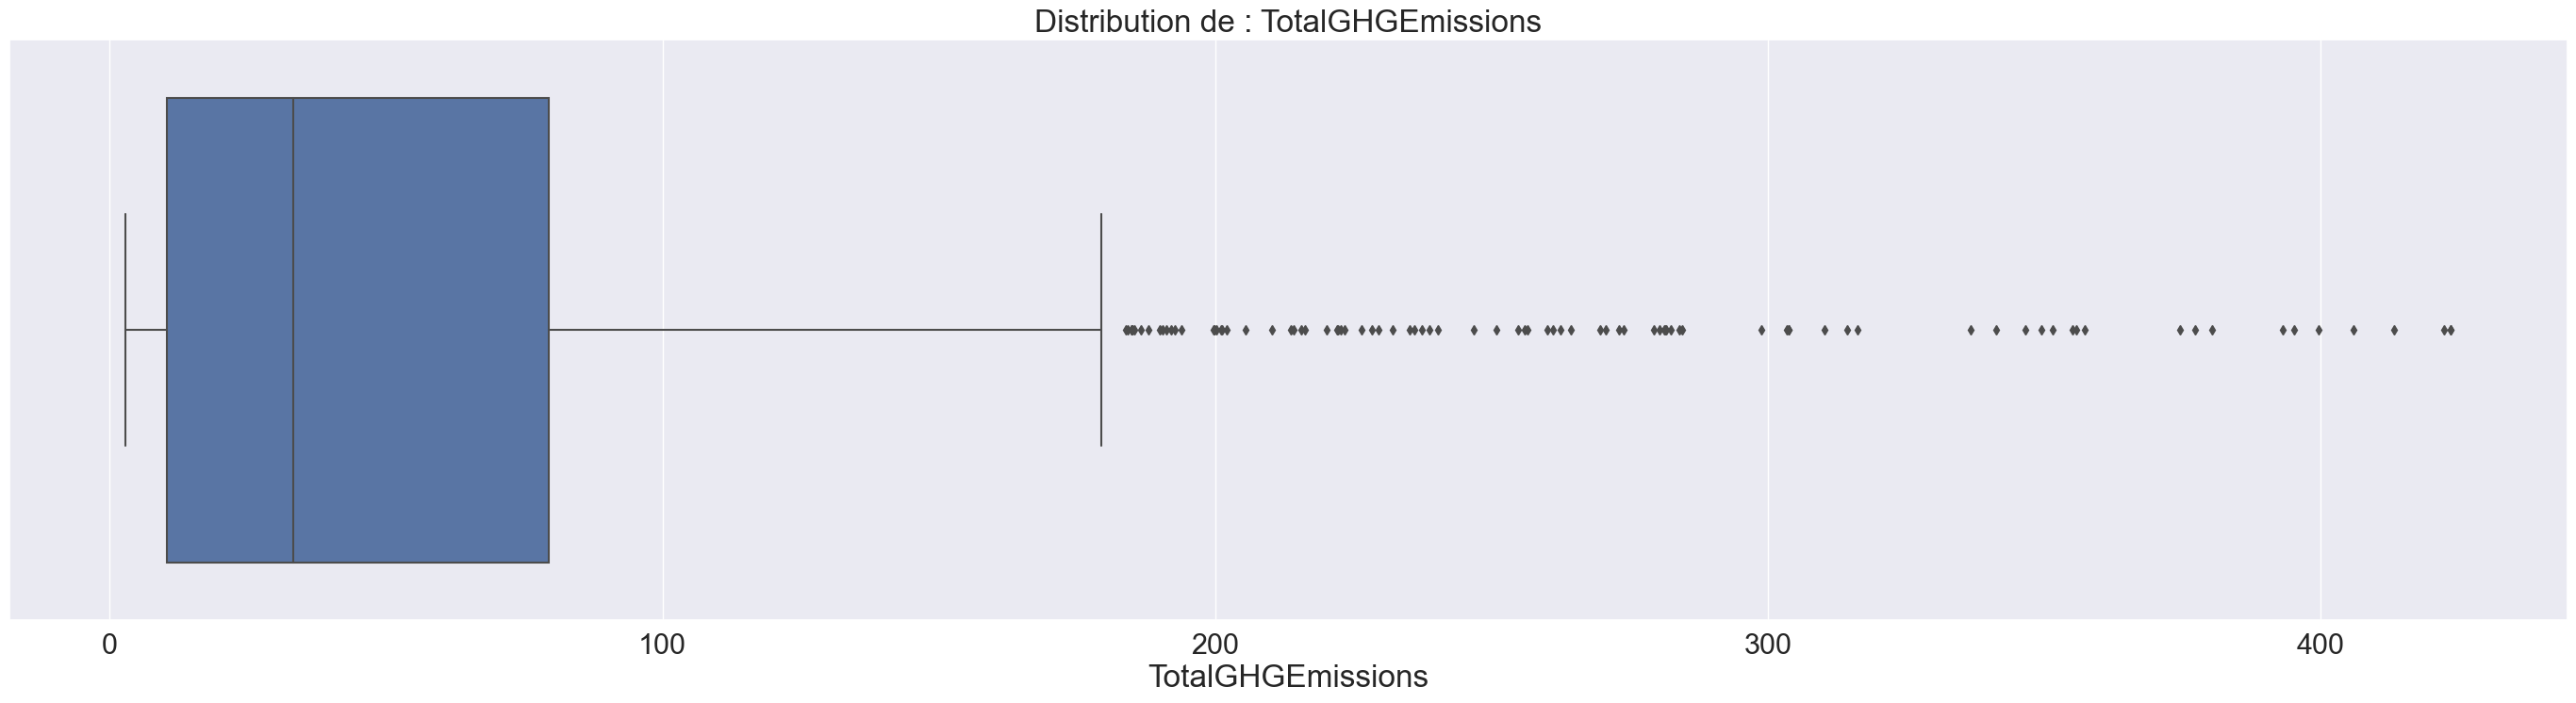

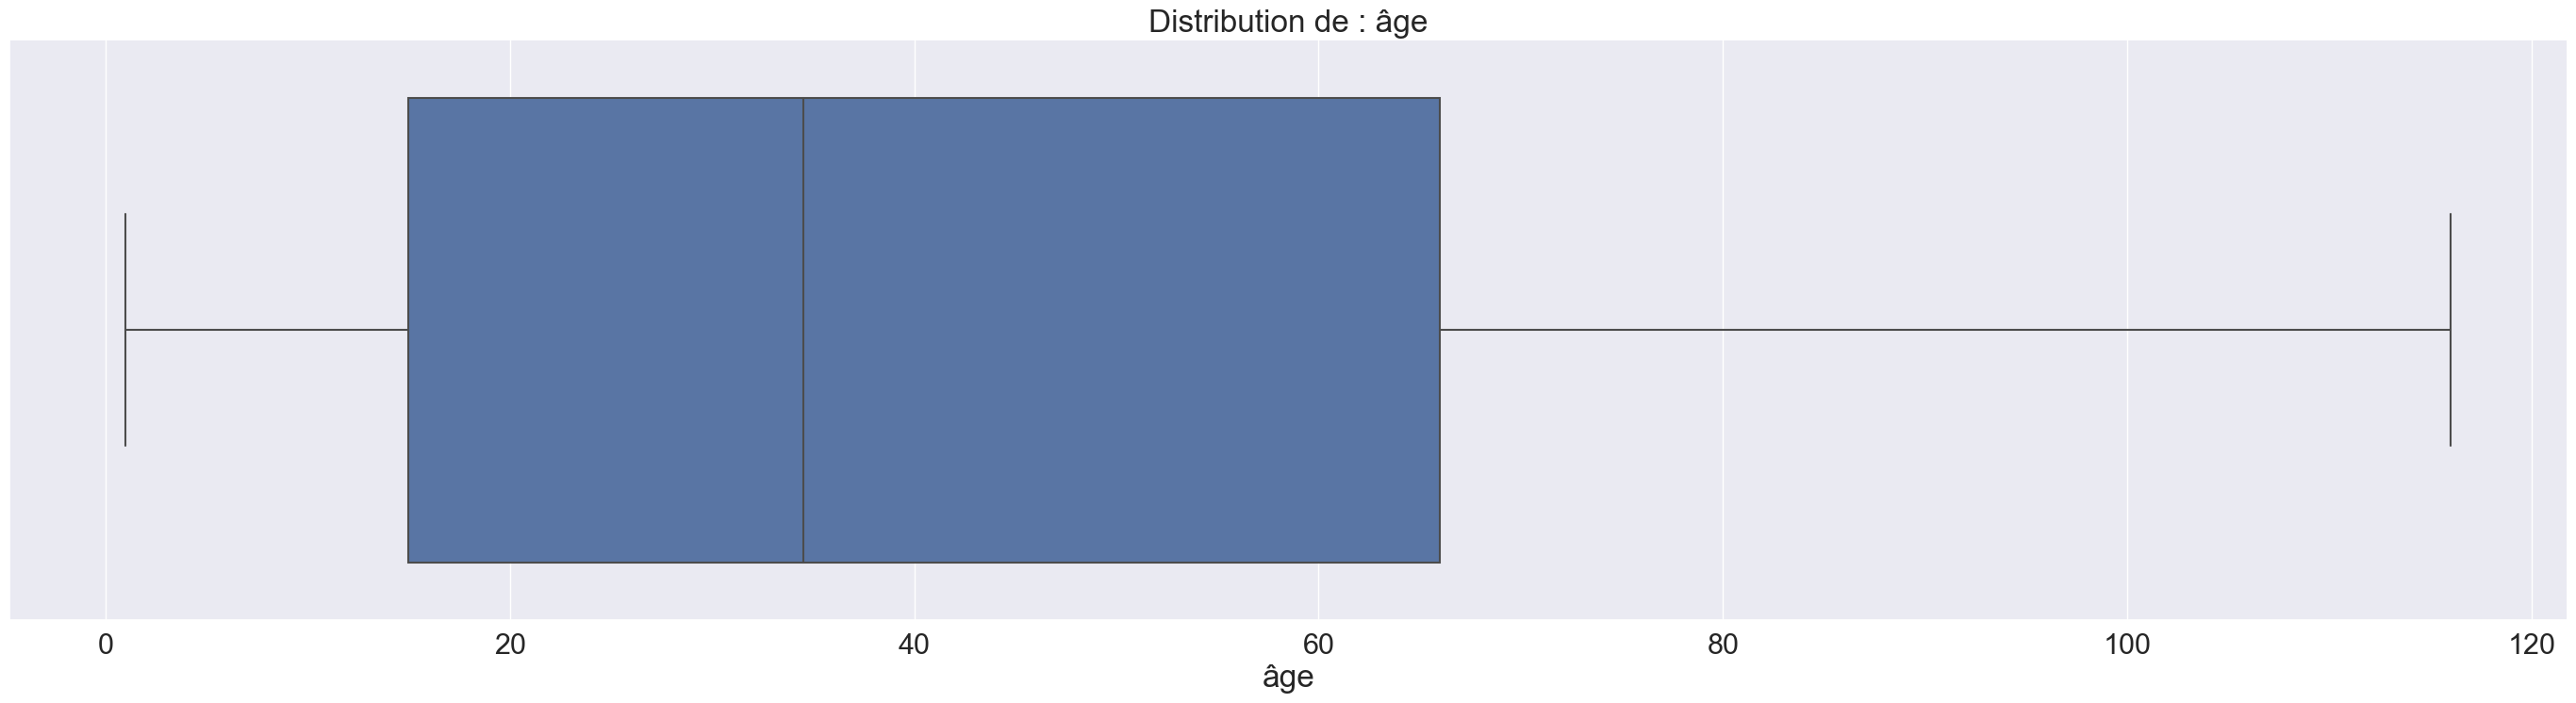

In [84]:
numeric_columns = data.select_dtypes(include = ['int32','float64']).columns
sns.set(font_scale=2)

for column in numeric_columns:
    plt.figure(figsize = (35, 8))
    
    sns.boxplot(x=data[column])
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()
    
sns.set(font_scale=1)

#### Analyse multivariée
- Matrice de corrélation

/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_2770/3870594014.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


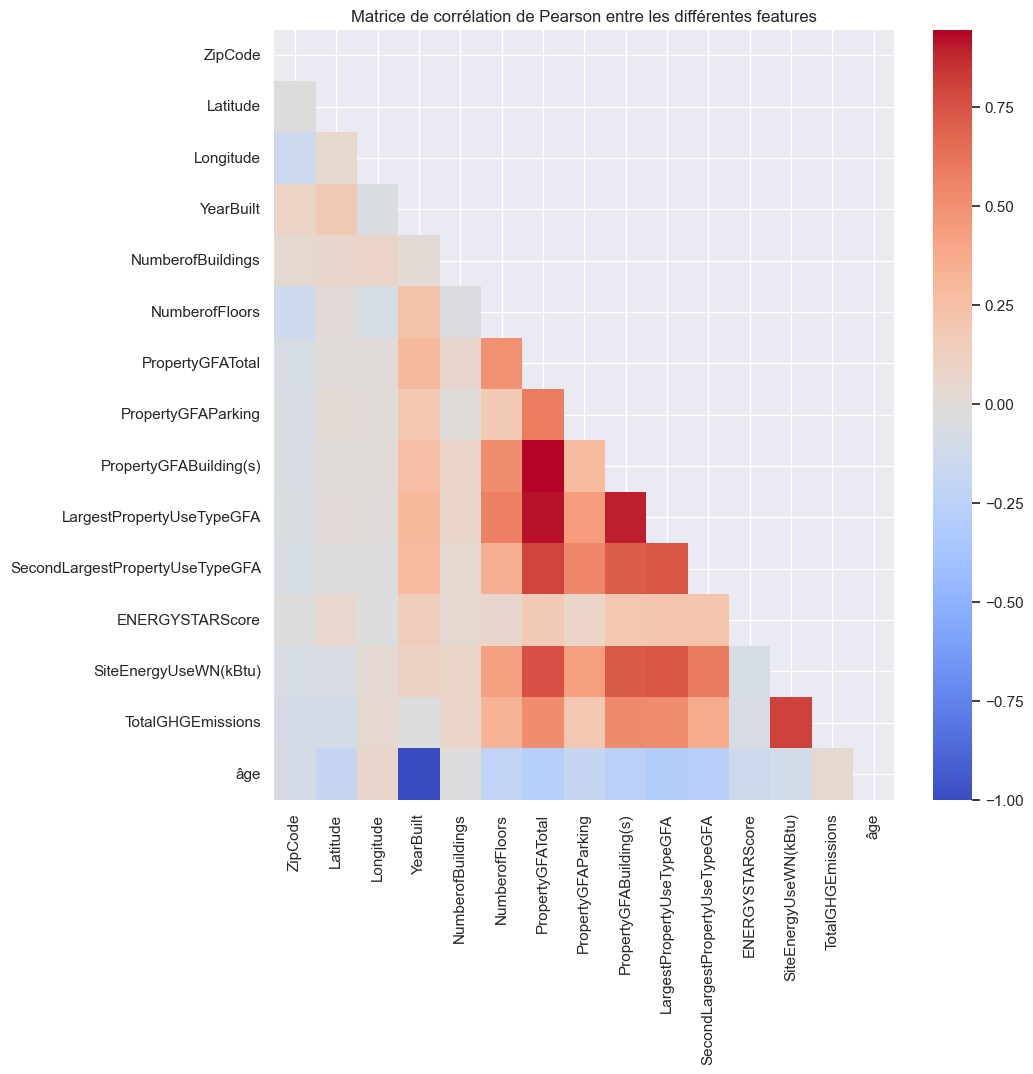

In [85]:
plt.figure(figsize=(10, 10))
plt.title('Matrice de corrélation de Pearson entre les différentes features')

corr = data[numeric_columns].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')
plt.show()

#### Observations

- Corrélation importante entre : PropertyGFATotal et PropertyGFABuilding(s) / LargestPropertyUseTypeGFA
- Corrélation importante entre PropertyGBABuilding(s) et LargestPropertyUseTypeGFA
- #### Corrélation importante entre TotalGHEmissions et SiteEnergyUseWN(kBtu) (On notera que ce sont les deux variables que l'on cherche à prédire, ce qui laisse présager.)

#### Indépendance des variables

In [86]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
def test_chi2(serie1, serie2):
    
    alpha = 0.03    
    
    #H0 : les variables sont indépendantes
    
    #print('tableau de contingence :\n', pd.crosstab(serie1.array, serie2.array))
    tab_contingence = pd.crosstab(serie1.array, serie2.array)
    stat_chi2, p, dof, expected_table = chi2_contingency(tab_contingence.values)
    print('chi2 : {},\np : {},\ndof : {}\n'.format(stat_chi2, p, dof))
    print('tableau de contingence : \n', tab_contingence)
    
    critical = chi2.ppf(1-alpha, dof) #
    #print('critital : ', critical)

    if p <= alpha:
        print('Variables non indépendantes (H0 rejetée) car p = {} <= alpha = {}'.format(p, alpha))
        return False
    
    else:
        print('H0 non rejetée car p = {} >= alpha = {}'.format(p, alpha))
        return True

In [87]:
x = pd.cut(data['SiteEnergyUseWN(kBtu)'], 20)
for column in data.select_dtypes(include = ['int32','float64']).columns:
    print('test d\'indépendance {} / {}'.format('SiteEnergyUseWN(kBtu)',column))
    if data[column].nunique() > 20 :
        y = pd.cut(data[column], 20).astype('category')
    else:
        y = data[column].astype('category')
    test_chi2(x, y)
   
    
    print('________________________________________________________________________________________________\n')

test d'indépendance SiteEnergyUseWN(kBtu) / ZipCode
chi2 : 151.1446530899426,
p : 0.9423719061871135,
dof : 180

tableau de contingence : 
 col_0                         (98100.902, 98105.9]  (98105.9, 98110.8]  \
row_0                                                                    
(325824.303, 1428106.903]     147                   61                   
(1428106.903, 2508776.119]    81                    48                   
(2508776.119, 3589445.334]    45                    20                   
(3589445.334, 4670114.55]     35                    20                   
(4670114.55, 5750783.766]     25                    21                   
(5750783.766, 6831452.981]    13                    7                    
(6831452.981, 7912122.197]    11                    7                    
(7912122.197, 8992791.412]    9                     4                    
(8992791.412, 10073460.628]   8                     2                    
(10073460.628, 11154129.844]  5               

#### Transformation variable de prédiction

/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_2770/1026540611.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['SiteEnergyUseWN(kBtu)'])


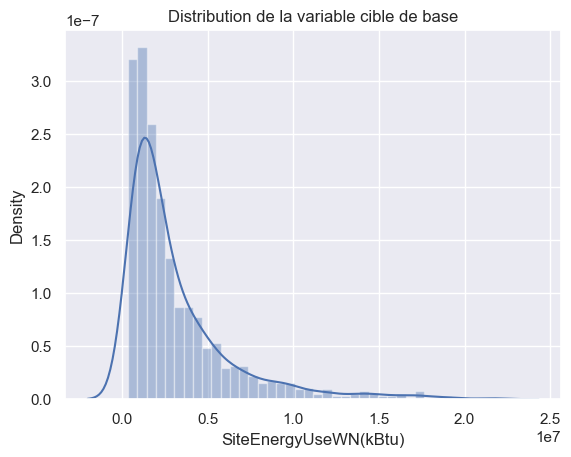

In [88]:
plt.title('Distribution de la variable cible de base')
sns.distplot(data['SiteEnergyUseWN(kBtu)'])

plt.show()

In [89]:
# Supposons que "test", "test1p", "test2" et "test2p" sont des tableaux numpy contenant vos données

# Transformation logarithmique réversible
test = np.log(data['SiteEnergyUseWN(kBtu)'])
test1p = np.log1p(data['SiteEnergyUseWN(kBtu)'])
test2 = np.log2(data['SiteEnergyUseWN(kBtu)'])
test2p = np.log2(1+data['SiteEnergyUseWN(kBtu)'])

Pour obtenir un bon algorithme, on va ajuster la distribution afin d'obtenir une variable dont la distribution se rapproche d'une loi normale.

/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_2770/3650304095.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test)
/var/folders/5b/97kkk3b96mjgj39npqqsf5y80000gn/T/ipykernel_2770/3650304095.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test1p)
/var/folders/5b/97kkk3b96mjg

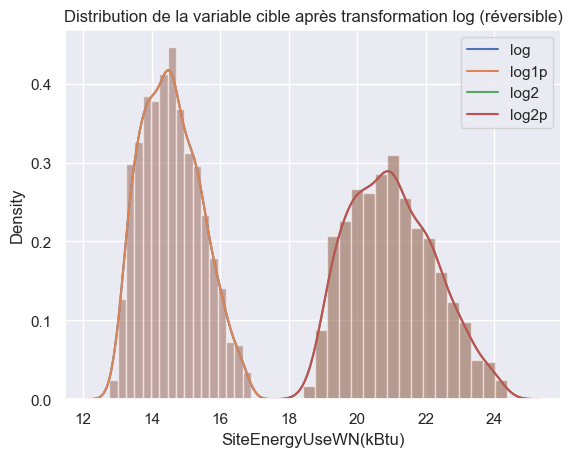

In [90]:
# Titre du graphique
plt.title('Distribution de la variable cible après transformation log (réversible)')

# Tracé des distributions
sns.distplot(test)
sns.distplot(test1p)
sns.distplot(test2)
sns.distplot(test2p)

# Légende
ax = plt.gca()
ax.legend(['log','log1p', 'log2', 'log2p'])

# Affichage du graphique
plt.show()


-  Les distributions semblent être transformées à l'aide de différentes fonctions logarithmiques.

In [91]:
data['Log2-SiteEnergyUseWN(kBtu)'] = test2p

- Après la transformation log2, nous allons conserver la variable.

#### Export des données nettoyées

In [92]:
data.to_csv('data_clean.csv', index=False)